# SUP ML 1 - PREPROCESSING

# Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth', 100)
#pd.set_option('display.max_info_columns', 10)
#pd.set_option('display.width', 10)
pd.set_option('display.max_rows', 150)
# Ajustar a opção para alinhar as colunas à esquerda
pd.set_option('display.colheader_justify', 'left')



import warnings
warnings.filterwarnings("ignore")

import time

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

# imports best practice pandas
import os


import math

#--------------------------------------------------------
# imports best practice sklearn
import sklearn
from sklearn import set_config


from sklearn.tree import DecisionTreeClassifier

# transformers
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
#from sklearn.preprocessing import

from sklearn.feature_selection import VarianceThreshold

# pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# model selection e hiperparameters optimization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedKFold, KFold

from sklearn.metrics import accuracy_score


# Importar train data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Extracción de datos de la BBDD corporativa vía SQL una muestra aleatoria de ambos grupos de clientes a lo largo de los últimos 12 meses. También hemos extraído los atributos de estos clientes en el mes anterior al abandono: tipo de cliente, características sociodemográficas, uso del servicio, productos contratados, etc.
df = pd.read_csv('/content/drive/MyDrive/NUCLIO/Machine Learning/Segundo entregable - ML/EJERCICIO-ML-Sup/data/telecom_churn_TRAINTEST.csv')

In [4]:
df_desc = pd.read_csv("/content/drive/MyDrive/NUCLIO/Machine Learning/Segundo entregable - ML/EJERCICIO-ML-Sup/data/variable_dictionary.csv")

In [5]:
#Facilitar la compreensión de las variables y su tipo original
tipos = df.dtypes
df_desc.insert(loc=df_desc.shape[1], column="Tipo", value=tipos.values)
df_desc

,Variable,Description,Tipo
0,rev,Mean monthly revenue (charge amount),float64
1,mou,Mean number of monthly minutes of use,float64
2,totmrc,Mean total monthly recurring charge,float64
3,da,Mean number of directory assisted calls,float64
4,ovrmou,Mean overage minutes of use,float64
5,ovrrev,Mean overage revenue,float64
6,vceovr,Mean revenue of voice overage,float64
7,datovr,Mean revenue of data overage,float64
8,roam,Mean number of roaming calls,float64
9,change_mou,Percentage change in monthly minutes of use vs previous three month average,float64


In [6]:
#Funciones Utiles

def listarNulos(dataset):
    #df_stat = dataset.isnull().sum()[(dataset.isnull().sum()>0)].sort_values(ascending=False).to_frame()
    #df_stat = dataset.isnull().sum().sort_values(ascending=False).to_frame()
    df_stat = dataset.isnull().sum().to_frame()
    df_stat.rename(columns={0: 'Nulos'}, inplace = True)
    percent = (df_stat["Nulos"]/dataset.shape[0]).mul(100)
    df_stat["Porcentaje"] = percent.round(2)
    tipos = dataset.dtypes
    df_stat["Tipo"] = df_stat.index.map(tipos)
    return df_stat[df_stat["Nulos"]>0].sort_values(by="Nulos", ascending=False)

def obtener_lista_variables(dataset, target):
    lista_numericas=[]
    lista_boolean=[]
    lista_categoricas=[]
    for i in dataset:
        if(i in dataset.select_dtypes("number")) and (i not in target):
              if (len(dataset[i].dropna().unique())!= 2):
                   lista_numericas.append(i)
              else:
                   lista_boolean.append(i)
        elif (i in dataset.select_dtypes("object")) and (i not in target):
              lista_categoricas.append(i)

    return lista_numericas, lista_boolean, lista_categoricas

def var_desc (lista):
    lista_retorno=list()
    retorno = df_desc[df_desc['Variable'].isin(lista)]
    return retorno

def plot_categorics(dataset, ord_unique):

    n_cols = 5
    n_rows = math.ceil(len(dataset)/n_cols)

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 10))


    if (ord_unique):
         lista_categoricas_ord_unique = df_churn[dataset].describe().T.sort_values(by="unique").index.to_list()
         data_show = dataset[lista_categoricas_ord_unique]
    else:
         data_show = dataset


    for i, col in enumerate(data_show):
        row_plot = i // n_rows
        col_plot = i % n_cols
        title_plot = df_desc[df_desc["Variable"]==col][" Description"].values[0]
        sns.countplot(x=col, data=data_show, ax=axes[row_plot,col_plot]).set_title(title_plot)


    # Ajustar o layout
    plt.tight_layout()
    plt.show()

    return

def reportFeature(dataset, nan_only=False, dataset_merge=df_desc):
    #df_stat = dataset.isnull().sum()[(dataset.isnull().sum()>0)].sort_values(ascending=False).to_frame()
    #df_stat = dataset.isnull().sum().sort_values(ascending=False).to_frame()
    df_stat = dataset.isnull().sum().to_frame()
    df_stat.rename(columns={0: 'Nulos'}, inplace = True)
    percent = (df_stat["Nulos"]/dataset.shape[0]).mul(100)
    df_stat["Porcentaje"] = percent.round(2)
    tipos = dataset.dtypes
    df_stat["Tipo"] = df_stat.index.map(tipos)
    for i, val in enumerate(df_stat.index):
        if(i in dataset_merge.columns):
            df_stat.loc[val,"Description"] = title_plot = dataset_merge[dataset_merge["Variable"]==val][" Description"].values[0]

    for i, val in enumerate(df_stat.index):
        df_stat.loc[val,"N_Unique"] = dataset[val].nunique()
        df_stat.loc[val,"Unique(10)"] = str(dataset[val].unique()[:10])

    if(nan_only):
         return df_stat[df_stat["Nulos"]>0].sort_values(by="Nulos", ascending=False)
    else:
         return df_stat.sort_values(by="Nulos", ascending=False)


def logCleaningOperation(dataset_log, dataset_main, list_variable, cat_operation, operation):

    for i in list_variable:
        tipo =  dataset_main.loc[i,"Tipo"]
        dataset_log.loc[dataset_log.shape[0]] = [i, tipo, cat_operation, operation]

    return dataset_log

In [7]:
reportFeature(df, nan_only=True)
#b = str(df_churn["mou"].nunique()) + " | " + str(df_churn["mou"].unique())
#b

,Nulos,Porcentaje,Tipo,N_Unique,Unique(10)
numbcars,43568,48.41,float64,3.0,[ 3. 1. 2. nan]
dwllsize,33764,37.52,object,15.0,['A' 'D' 'O' nan 'E' 'J' 'C' 'B' 'I' 'N']
HHstatin,33032,36.70,object,6.0,['C' 'I' nan 'B' 'A' 'G' 'H']
ownrent,29491,32.77,object,2.0,['O' nan 'R']
dwlltype,27978,31.09,object,2.0,['S' 'M' nan]
lor,26502,29.45,float64,16.0,[15. 1. 7. 6. 5. 8. 0. 3. 4. 11.]
income,22196,24.66,float64,9.0,[ 4. 5. 6. 9. 1. 7. 3. nan 8. 2.]
adults,20033,22.26,float64,6.0,[ 1. 2. 4. 3. 5. nan 6.]
infobase,19403,21.56,object,1.0,['M' nan]
hnd_webcap,9519,10.58,object,3.0,['WCMB' 'WC' nan 'UNKW']


In [8]:
df_desc[df_desc["Variable"]=="mou"]

,Variable,Description,Tipo
1,mou,Mean number of monthly minutes of use,float64


In [9]:
print(df.shape)

(90000, 100)


In [10]:
df.head(10)
# Columna area, se podría a lo mejor limpiar, quitar la palabra "area"
# No hay fechas, columna months, que supongo sería intentar predecir esa columna + 1
# Tenemos una columna que se llama churn: Instance of churn between 31-60 days after observation date

,rev,mou,totmrc,da,ovrmou,ovrrev,vceovr,datovr,roam,change_mou,change_rev,drop_vce,drop_dat,blck_vce,blck_dat,unan_vce,unan_dat,plcd_vce,plcd_dat,recv_vce,recv_sms,comp_vce,comp_dat,custcare,ccrndmou,cc_mou,inonemin,threeway,mou_cvce,mou_cdat,mou_rvce,owylis_vce,mouowylisv,iwylis_vce,mouiwylisv,peak_vce,peak_dat,mou_peav,mou_pead,opk_vce,opk_dat,mou_opkv,mou_opkd,drop_blk,attempt,complete,callfwdv,callwait,churn,months,uniqsubs,actvsubs,new_cell,crclscod,asl_flag,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,prizm_social_one,area,dualband,refurb_new,hnd_price,phones,models,hnd_webcap,truck,rv,ownrent,lor,dwlltype,marital,adults,infobase,income,numbcars,HHstatin,dwllsize,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,23.9975,219.25,22.500,0.2475,0.00,0.00,0.00,0.0,0.0,-157.25,-18.9975,0.666667,0.0,0.666667,0.0,6.333333,0.0,52.333333,0.0,42.333333,0.0,45.000000,0.0,0.000000,0.000000,0.000000,18.000000,0.000000,90.643333,0.0,97.176667,0.000000,0.000000,0.000000,0.000000,58.000000,0.0,132.600000,0.0,24.000000,0.0,55.220000,0.0,1.333333,52.333333,45.000000,0.0,0.333333,1,61,2,1,U,A,N,1652,4228.00000,1504.62,1453.44,4085.00,1602,29.66,83.37,32.69,272,116,30,322.0,136.0,38.0,S,NORTHWEST/ROCKY MOUNTAIN AREA,Y,N,149.98999,2.0,2.0,WCMB,0.0,0.0,O,15.0,S,S,1.0,M,4.0,3.0,C,A,0.0,N,U,U,U,U,U,Y,361.0,1000001
1,57.4925,482.75,37.425,0.2475,22.75,9.10,9.10,0.0,0.0,532.25,50.9875,8.333333,0.0,1.000000,0.0,61.333333,0.0,263.333333,0.0,69.000000,0.0,193.333333,0.0,1.666667,6.333333,5.463333,53.000000,0.333333,189.396667,0.0,55.280000,46.333333,24.216667,6.333333,3.696667,83.666667,0.0,75.333333,0.0,157.000000,0.0,169.343333,0.0,9.333333,263.333333,193.333333,0.0,5.666667,0,56,1,1,N,EA,N,14654,26400.00000,2851.68,2833.88,26367.00,14624,51.53,479.40,265.89,305,158,40,477.0,275.0,48.0,U,CHICAGO AREA,N,N,NaN,7.0,6.0,WC,1.0,1.0,NaN,1.0,S,S,1.0,M,5.0,1.0,C,A,0.0,Z,U,U,U,U,U,Y,240.0,1000002
2,16.9900,10.25,16.990,0.0000,0.00,0.00,0.00,0.0,0.0,-4.25,0.0000,0.333333,0.0,0.000000,0.0,2.666667,0.0,9.000000,0.0,0.333333,0.0,6.000000,0.0,0.000000,0.000000,0.000000,0.333333,0.000000,5.426667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.0,5.193333,0.0,1.000000,0.0,0.233333,0.0,0.333333,9.000000,6.000000,0.0,0.000000,1,58,1,1,Y,C,N,7903,24385.05333,2155.91,1934.47,24303.05,7888,34.54,433.98,140.86,12,7,17,11.0,6.0,17.0,S,GREAT LAKES AREA,N,N,29.98999,2.0,1.0,NaN,0.0,0.0,O,7.0,S,M,2.0,M,5.0,2.0,C,A,0.0,N,U,Y,U,U,U,Y,1504.0,1000003
3,38.0000,7.50,38.000,0.0000,0.00,0.00,0.00,0.0,0.0,-1.50,0.0000,0.000000,0.0,0.000000,0.0,0.000000,0.0,3.666667,0.0,1.333333,0.0,3.666667,0.0,0.000000,0.000000,0.000000,1.333333,0.000000,8.410000,0.0,0.413333,0.333333,0.256667,0.000000,0.000000,1.333333,0.0,3.380000,0.0,3.666667,0.0,5.450000,0.0,0.000000,3.666667,3.666667,0.0,0.000000,0,60,1,1,Y,B,N,1502,3065.00000,2000.90,1941.81,3035.00,1479,40.45,63.23,30.81,8,3,38,50.0,25.0,40.0,T,CHICAGO AREA,N,N,29.98999,1.0,1.0,NaN,0.0,0.0,NaN,6.0,M,M,4.0,M,6.0,1.0,C,D,0.0,U,Y,U,U,U,U,Y,1812.0,1000004
4,55.2300,570.50,71.980,0.0000,0.00,0.00,0.00,0.0,0.0,38.50,0.0000,9.666667,0.0,0.666667,0.0,77.000000,0.0,222.333333,0.0,94.666667,0.0,137.000000,0.0,8.666667,15.000000,11.076667,66.000000,0.000000,285.233333,0.0,106.330000,14.666667,10.816667,0.666667,0.366667,97.333333,0.0,173.476667,0.0,90.333333,0.0,218.086667,0.0,10.333333,222.333333,137.000000,0.0,0.000000,0,57,1,1,Y,A,N,4485,14028.00000,2181.12,2166.48,13965.00,4452,38.69,249.38,79.50,558,191,55,586.0,196.0,80.0,U,NEW ENGLAND AREA,Y,N,149.98999,6.0,4.0,WCMB,0.0,0.0,R,5.0,M,S,1.0,M,6.0,1.0,C,O,0.0,I,U,U,U,U,U,Y,434.0,1000005
5,82.2750,1312.25,75.000,1.2375,0.00,0.00,0.00,0.0,0.0,156.75,8.1450,52.000000,0.0,7.666667,0.0,76.000000,0.0,702.000000,0.0,365.000000,0.0,577.333333,0.0,4.333333,11.000000,7.753333,301.666667,1.333333,369.536667,0.0,200.320000,370.333333,243.213333,147.000000,85.146667,555.666667,0.0,382.096667,0.0,


Cuando se dice que los atributos del mes "n" se utilizan para predecir el abandono en el mes "n+1", significa que los datos recopilados hasta el mes "n" se utilizan como base para predecir si un cliente abandonará en el mes siguiente, es decir, en el "mes n+1".

Por ejemplo, si estamos en el mes de enero (mes "n") y queremos predecir el abandono para febrero (mes "n+1"), utilizaríamos los datos de comportamiento, interacciones, características demográficas, etc., recopilados hasta enero para predecir la probabilidad de que un cliente abandone en febrero.

Es como si estuviéramos mirando hacia adelante en el tiempo: utilizamos la información actual para intentar predecir lo que ocurrirá en el futuro inmediato con respecto al abandono de clientes. Esto es importante en estrategias de retención, ya que permite tomar medidas preventivas basadas en las tendencias y comportamientos observados hasta el momento actual.

In [11]:
# Ponemos Customer_ID como índice
df.set_index("Customer_ID")

,rev,mou,totmrc,da,ovrmou,ovrrev,vceovr,datovr,roam,change_mou,change_rev,drop_vce,drop_dat,blck_vce,blck_dat,unan_vce,unan_dat,plcd_vce,plcd_dat,recv_vce,recv_sms,comp_vce,comp_dat,custcare,ccrndmou,cc_mou,inonemin,threeway,mou_cvce,mou_cdat,mou_rvce,owylis_vce,mouowylisv,iwylis_vce,mouiwylisv,peak_vce,peak_dat,mou_peav,mou_pead,opk_vce,opk_dat,mou_opkv,mou_opkd,drop_blk,attempt,complete,callfwdv,callwait,churn,months,uniqsubs,actvsubs,new_cell,crclscod,asl_flag,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,prizm_social_one,area,dualband,refurb_new,hnd_price,phones,models,hnd_webcap,truck,rv,ownrent,lor,dwlltype,marital,adults,infobase,income,numbcars,HHstatin,dwllsize,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays
Customer_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000001,23.9975,219.25,22.500,0.2475,0.00,0.000,0.0,0.000,0.0000,-157.25,-18.9975,0.666667,0.0,0.666667,0.0,6.333333,0.000000,52.333333,0.000000,42.333333,0.0,45.000000,0.0,0.000000,0.000000,0.000000,18.000000,0.000000,90.643333,0.0,97.176667,0.000000,0.000000,0.000000,0.000000,58.000000,0.0,132.600000,0.0,24.000000,0.0,55.220000,0.0,1.333333,52.333333,45.000000,0.0,0.333333,1,61,2,1,U,A,N,1652,4228.00000,1504.62,1453.44,4085.00,1602,29.66,83.37,32.69,272,116,30,322.0,136.0,38.0,S,NORTHWEST/ROCKY MOUNTAIN AREA,Y,N,149.98999,2.0,2.0,WCMB,0.0,0.0,O,15.0,S,S,1.0,M,4.0,3.0,C,A,0.0,N,U,U,U,U,U,Y,361.0
1000002,57.4925,482.75,37.425,0.2475,22.75,9.100,9.1,0.000,0.0000,532.25,50.9875,8.333333,0.0,1.000000,0.0,61.333333,0.000000,263.333333,0.000000,69.000000,0.0,193.333333,0.0,1.666667,6.333333,5.463333,53.000000,0.333333,189.396667,0.0,55.280000,46.333333,24.216667,6.333333,3.696667,83.666667,0.0,75.333333,0.0,157.000000,0.0,169.343333,0.0,9.333333,263.333333,193.333333,0.0,5.666667,0,56,1,1,N,EA,N,14654,26400.00000,2851.68,2833.88,26367.00,14624,51.53,479.40,265.89,305,158,40,477.0,275.0,48.0,U,CHICAGO AREA,N,N,NaN,7.0,6.0,WC,1.0,1.0,NaN,1.0,S,S,1.0,M,5.0,1.0,C,A,0.0,Z,U,U,U,U,U,Y,240.0
1000003,16.9900,10.25,16.990,0.0000,0.00,0.000,0.0,0.000,0.0000,-4.25,0.0000,0.333333,0.0,0.000000,0.0,2.666667,0.000000,9.000000,0.000000,0.333333,0.0,6.000000,0.0,0.000000,0.000000,0.000000,0.333333,0.000000,5.426667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.0,5.193333,0.0,1.000000,0.0,0.233333,0.0,0.333333,9.000000,6.000000,0.0,0.000000,1,58,1,1,Y,C,N,7903,24385.05333,2155.91,1934.47,24303.05,7888,34.54,433.98,140.86,12,7,17,11.0,6.0,17.0,S,GREAT LAKES AREA,N,N,29.98999,2.0,1.0,NaN,0.0,0.0,O,7.0,S,M,2.0,M,5.0,2.0,C,A,0.0,N,U,Y,U,U,U,Y,1504.0
1000004,38.0000,7.50,38.000,0.0000,0.00,0.000,0.0,0.000,0.0000,-1.50,0.0000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,3.666667,0.000000,1.333333,0.0,3.666667,0.0,0.000000,0.000000,0.000000,1.333333,0.000000,8.410000,0.0,0.413333,0.333333,0.256667,0.000000,0.000000,1.333333,0.0,3.380000,0.0,3.666667,0.0,5.450000,0.0,0.000000,3.666667,3.666667,0.0,0.000000,0,60,1,1,Y,B,N,1502,3065.00000,2000.90,1941.81,3035.00,1479,40.45,63.23,30.81,8,3,38,50.0,25.0,40.0,T,CHICAGO AREA,N,N,29.98999,1.0,1.0,NaN,0.0,0.0,NaN,6.0,M,M,4.0,M,6.0,1.0,C,D,0.0,U,Y,U,U,U,U,Y,1812.0
1000005,55.2300,570.50,71.980,0.0000,0.00,0.000,0.0,0.000,0.0000,38.50,0.0000,9.666667,0.0,0.666667,0.0,77.000000,0.000000,222.333333,0.000000,94.666667,0.0,137.000000,0.0,8.666667,15.000000,11.076667,66.000000,0.000000,285.233333,0.0,106.330000,14.666667,10.816667,0.666667,0.366667,97.333333,0.0,173.476667,0.0,90.333333,0.0,218.086667,0.0,10.333333,222.333333,137.000000,0.0,0.000000,0,57,1,1,Y,A,N,4485,14028.00000,2181.12,2166.48,13965.00,4452,38.69,249.38,79.50,558,191,55,586.0,196.0,80.0,U,NEW ENGLAND AREA,Y,N,149.98999,6.0,4.0,WCMB,0.0,0.0,R,5.0,M,S,1.0,M,6.0,1.0,C,O,0.0,I,U,U,U,U,U,Y,434.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

# EDA: Analisis Exploratorio

In [12]:
df.describe(include="all").T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
rev,89866.0,NaN,NaN,NaN,58.312895,46.084103,-5.8625,33.0275,47.6675,70.19375,3843.2625
mou,89866.0,NaN,NaN,NaN,504.277946,516.170057,0.0,148.5,349.0,689.0,12206.75
totmrc,89866.0,NaN,NaN,NaN,45.880669,23.370435,-26.915,30.0,44.99,59.99,409.99
da,89866.0,NaN,NaN,NaN,0.877813,2.173665,0.0,0.0,0.2475,0.7425,159.39
ovrmou,89866.0,NaN,NaN,NaN,40.798976,96.970619,0.0,0.0,2.5,41.25,4320.75
ovrrev,89866.0,NaN,NaN,NaN,13.289932,30.123282,0.0,0.0,0.9,13.9125,1102.4
vceovr,89866.0,NaN,NaN,NaN,13.046046,29.719581,0.0,0.0,0.6,13.5625,896.0875
datovr,89866.0,NaN,NaN,NaN,0.240786,3.012631,0.0,0.0,0.0,0.0,423.54
roam,89866.0,NaN,NaN,NaN,1.308197,15.374215,0.0,0.0,0.0,0.2575,3685.2
change_mou,89405.0,NaN,NaN,NaN,-13.786987,271.624916,-3875.0,-85.75,-6.5,61.25,31219.25


In [13]:
reportFeature(df, nan_only=True)
#b = str(df_churn["mou"].nunique()) + " | " + str(df_churn["mou"].unique())
#b

,Nulos,Porcentaje,Tipo,N_Unique,Unique(10)
numbcars,43568,48.41,float64,3.0,[ 3. 1. 2. nan]
dwllsize,33764,37.52,object,15.0,['A' 'D' 'O' nan 'E' 'J' 'C' 'B' 'I' 'N']
HHstatin,33032,36.70,object,6.0,['C' 'I' nan 'B' 'A' 'G' 'H']
ownrent,29491,32.77,object,2.0,['O' nan 'R']
dwlltype,27978,31.09,object,2.0,['S' 'M' nan]
lor,26502,29.45,float64,16.0,[15. 1. 7. 6. 5. 8. 0. 3. 4. 11.]
income,22196,24.66,float64,9.0,[ 4. 5. 6. 9. 1. 7. 3. nan 8. 2.]
adults,20033,22.26,float64,6.0,[ 1. 2. 4. 3. 5. nan 6.]
infobase,19403,21.56,object,1.0,['M' nan]
hnd_webcap,9519,10.58,object,3.0,['WCMB' 'WC' nan 'UNKW']


## Distribución del target

In [14]:
target = "churn"

print(df[target].info(),"\n")
print(df[target].value_counts())
df[[target]].head()

<class 'pandas.core.series.Series'>
RangeIndex: 90000 entries, 0 to 89999
Series name: churn
Non-Null Count  Dtype
--------------  -----
90000 non-null  int64
dtypes: int64(1)
memory usage: 703.2 KB
None 

1    45800
0    44200
Name: churn, dtype: int64


,churn
0,1
1,0
2,1
3,0
4,0


In [15]:
df["churn"].value_counts()

1    45800
0    44200
Name: churn, dtype: int64

In [16]:
target = 'churn'
features = df.columns[df.columns!=target]

# Divide dataset en matriz de variables (X) y output (y)
X = df[features]
y = df[target]

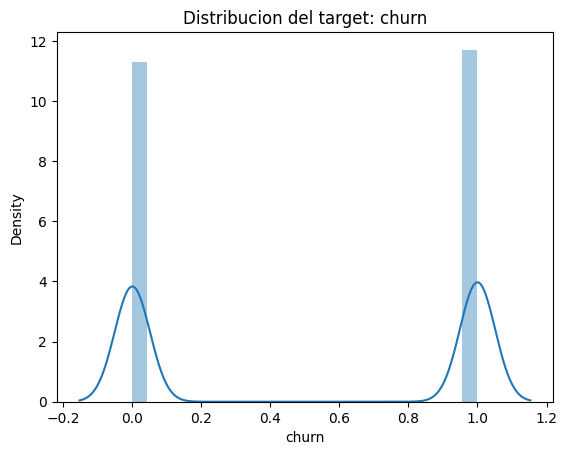

In [17]:
#Distribucion target
sns.distplot(y)
plt.title('Distribucion del target: '+target)
plt.show()

<Axes: xlabel='churn', ylabel='Count'>

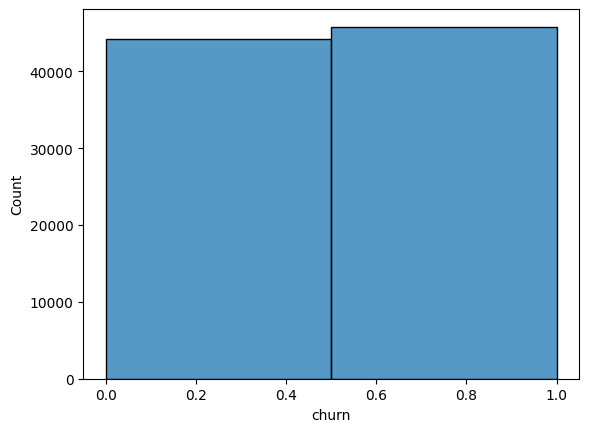

In [18]:
sns.histplot(df[target], bins=2)

## Analisis Univariable

In [19]:
#Split de variables
lista_numericas, lista_num_binaria, lista_categoricas = obtener_lista_variables(df,target)

**Análisis de variables numéricas**

In [20]:
# lista_numericas
df[lista_numericas].head(3)

,rev,mou,totmrc,da,ovrmou,ovrrev,vceovr,datovr,roam,change_mou,change_rev,drop_vce,drop_dat,blck_vce,blck_dat,unan_vce,unan_dat,plcd_vce,plcd_dat,recv_vce,recv_sms,comp_vce,comp_dat,custcare,ccrndmou,cc_mou,inonemin,threeway,mou_cvce,mou_cdat,mou_rvce,owylis_vce,mouowylisv,iwylis_vce,mouiwylisv,peak_vce,peak_dat,mou_peav,mou_pead,opk_vce,opk_dat,mou_opkv,mou_opkd,drop_blk,attempt,complete,callfwdv,callwait,months,uniqsubs,actvsubs,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,hnd_price,phones,models,lor,adults,income,numbcars,eqpdays,Customer_ID
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,-18.9975,0.666667,0.0,0.666667,0.0,6.333333,0.0,52.333333,0.0,42.333333,0.0,45.000000,0.0,0.000000,0.000000,0.000000,18.000000,0.000000,90.643333,0.0,97.176667,0.000000,0.000000,0.000000,0.000000,58.000000,0.0,132.600000,0.0,24.0,0.0,55.220000,0.0,1.333333,52.333333,45.000000,0.0,0.333333,61,2,1,1652,4228.00000,1504.62,1453.44,4085.00,1602,29.66,83.37,32.69,272,116,30,322.0,136.0,38.0,149.98999,2.0,2.0,15.0,1.0,4.0,3.0,361.0,1000001
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,50.9875,8.333333,0.0,1.000000,0.0,61.333333,0.0,263.333333,0.0,69.000000,0.0,193.333333,0.0,1.666667,6.333333,5.463333,53.000000,0.333333,189.396667,0.0,55.280000,46.333333,24.216667,6.333333,3.696667,83.666667,0.0,75.333333,0.0,157.0,0.0,169.343333,0.0,9.333333,263.333333,193.333333,0.0,5.666667,56,1,1,14654,26400.00000,2851.68,2833.88,26367.00,14624,51.53,479.40,265.89,305,158,40,477.0,275.0,48.0,NaN,7.0,6.0,1.0,1.0,5.0,1.0,240.0,1000002
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,0.0000,0.333333,0.0,0.000000,0.0,2.666667,0.0,9.000000,0.0,0.333333,0.0,6.000000,0.0,0.000000,0.000000,0.000000,0.333333,0.000000,5.426667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.0,5.193333,0.0,1.0,0.0,0.233333,0.0,0.333333,9.000000,6.000000,0.0,0.000000,58,1,1,7903,24385.05333,2155.91,1934.47,24303.05,7888,34.54,433.98,140.86,12,7,17,11.0,6.0,17.0,29.98999,2.0,1.0,7.0,2.0,5.0,2.0,1504.0,1000003


In [21]:
df_stat = df[lista_numericas].describe().T
pd.set_option('display.max_rows', None)  # Mostrar todas las filas
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
df_stat

,count,mean,std,min,25%,50%,75%,max
rev,89866.0,5.831289e+01,46.084103,-5.862500e+00,3.302750e+01,4.766750e+01,7.019375e+01,3.843262e+03
mou,89866.0,5.042779e+02,516.170057,0.000000e+00,1.485000e+02,3.490000e+02,6.890000e+02,1.220675e+04
totmrc,89866.0,4.588067e+01,23.370435,-2.691500e+01,3.000000e+01,4.499000e+01,5.999000e+01,4.099900e+02
da,89866.0,8.778126e-01,2.173665,0.000000e+00,0.000000e+00,2.475000e-01,7.425000e-01,1.593900e+02
ovrmou,89866.0,4.079898e+01,96.970619,0.000000e+00,0.000000e+00,2.500000e+00,4.125000e+01,4.320750e+03
ovrrev,89866.0,1.328993e+01,30.123282,0.000000e+00,0.000000e+00,9.000000e-01,1.391250e+01,1.102400e+03
vceovr,89866.0,1.304605e+01,29.719581,0.000000e+00,0.000000e+00,6.000000e-01,1.356250e+01,8.960875e+02
datovr,89866.0,2.407858e-01,3.012631,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.235400e+02
roam,89866.0,1.308197e+00,15.374215,0.000000e+00,0.000000e+00,0.000000e+00,2.575000e-01,3.685200e+03
change_mou,89405.0,-1.378699e+01,271.624916,-3.875000e+03,-8.575000e+01,-6.500000e+00,6.125000e+01,3.121925e+04


In [22]:
#Verificación de valores numéricos < 0
df_stat[df_stat["min"]<0]


,count,mean,std,min,25%,50%,75%,max
rev,89866.0,58.312895,46.084103,-5.8625,33.0275,47.6675,70.19375,3843.2625
totmrc,89866.0,45.880669,23.370435,-26.9150,30.0000,44.9900,59.99000,409.9900
change_mou,89405.0,-13.786987,271.624916,-3875.0000,-85.7500,-6.5000,61.25000,31219.2500
change_rev,89405.0,-1.074666,50.565668,-1107.7400,-7.2125,-0.3150,1.53750,9963.6575
avg6rev,88593.0,58.266691,40.483529,-2.0000,34.0000,49.0000,70.00000,866.0000
eqpdays,89999.0,402.419438,252.821660,-5.0000,227.0000,359.0000,547.00000,1812.0000


In [23]:
# Valores numéricos < 0
var_desc(df_stat[df_stat["min"]<0].index)


,Variable,Description,Tipo
0,rev,Mean monthly revenue (charge amount),float64
2,totmrc,Mean total monthly recurring charge,float64
9,change_mou,Percentage change in monthly minutes of use vs previous three month average,float64
10,change_rev,Percentage change in monthly revenue vs previous three month average,float64
69,avg6rev,Average monthly revenue over the previous six months,float64
98,eqpdays,Number of days (age) of current equipment,float64


In [24]:
dict_chequeo = {"variables negativas": df_stat[df_stat["min"]<0].index}


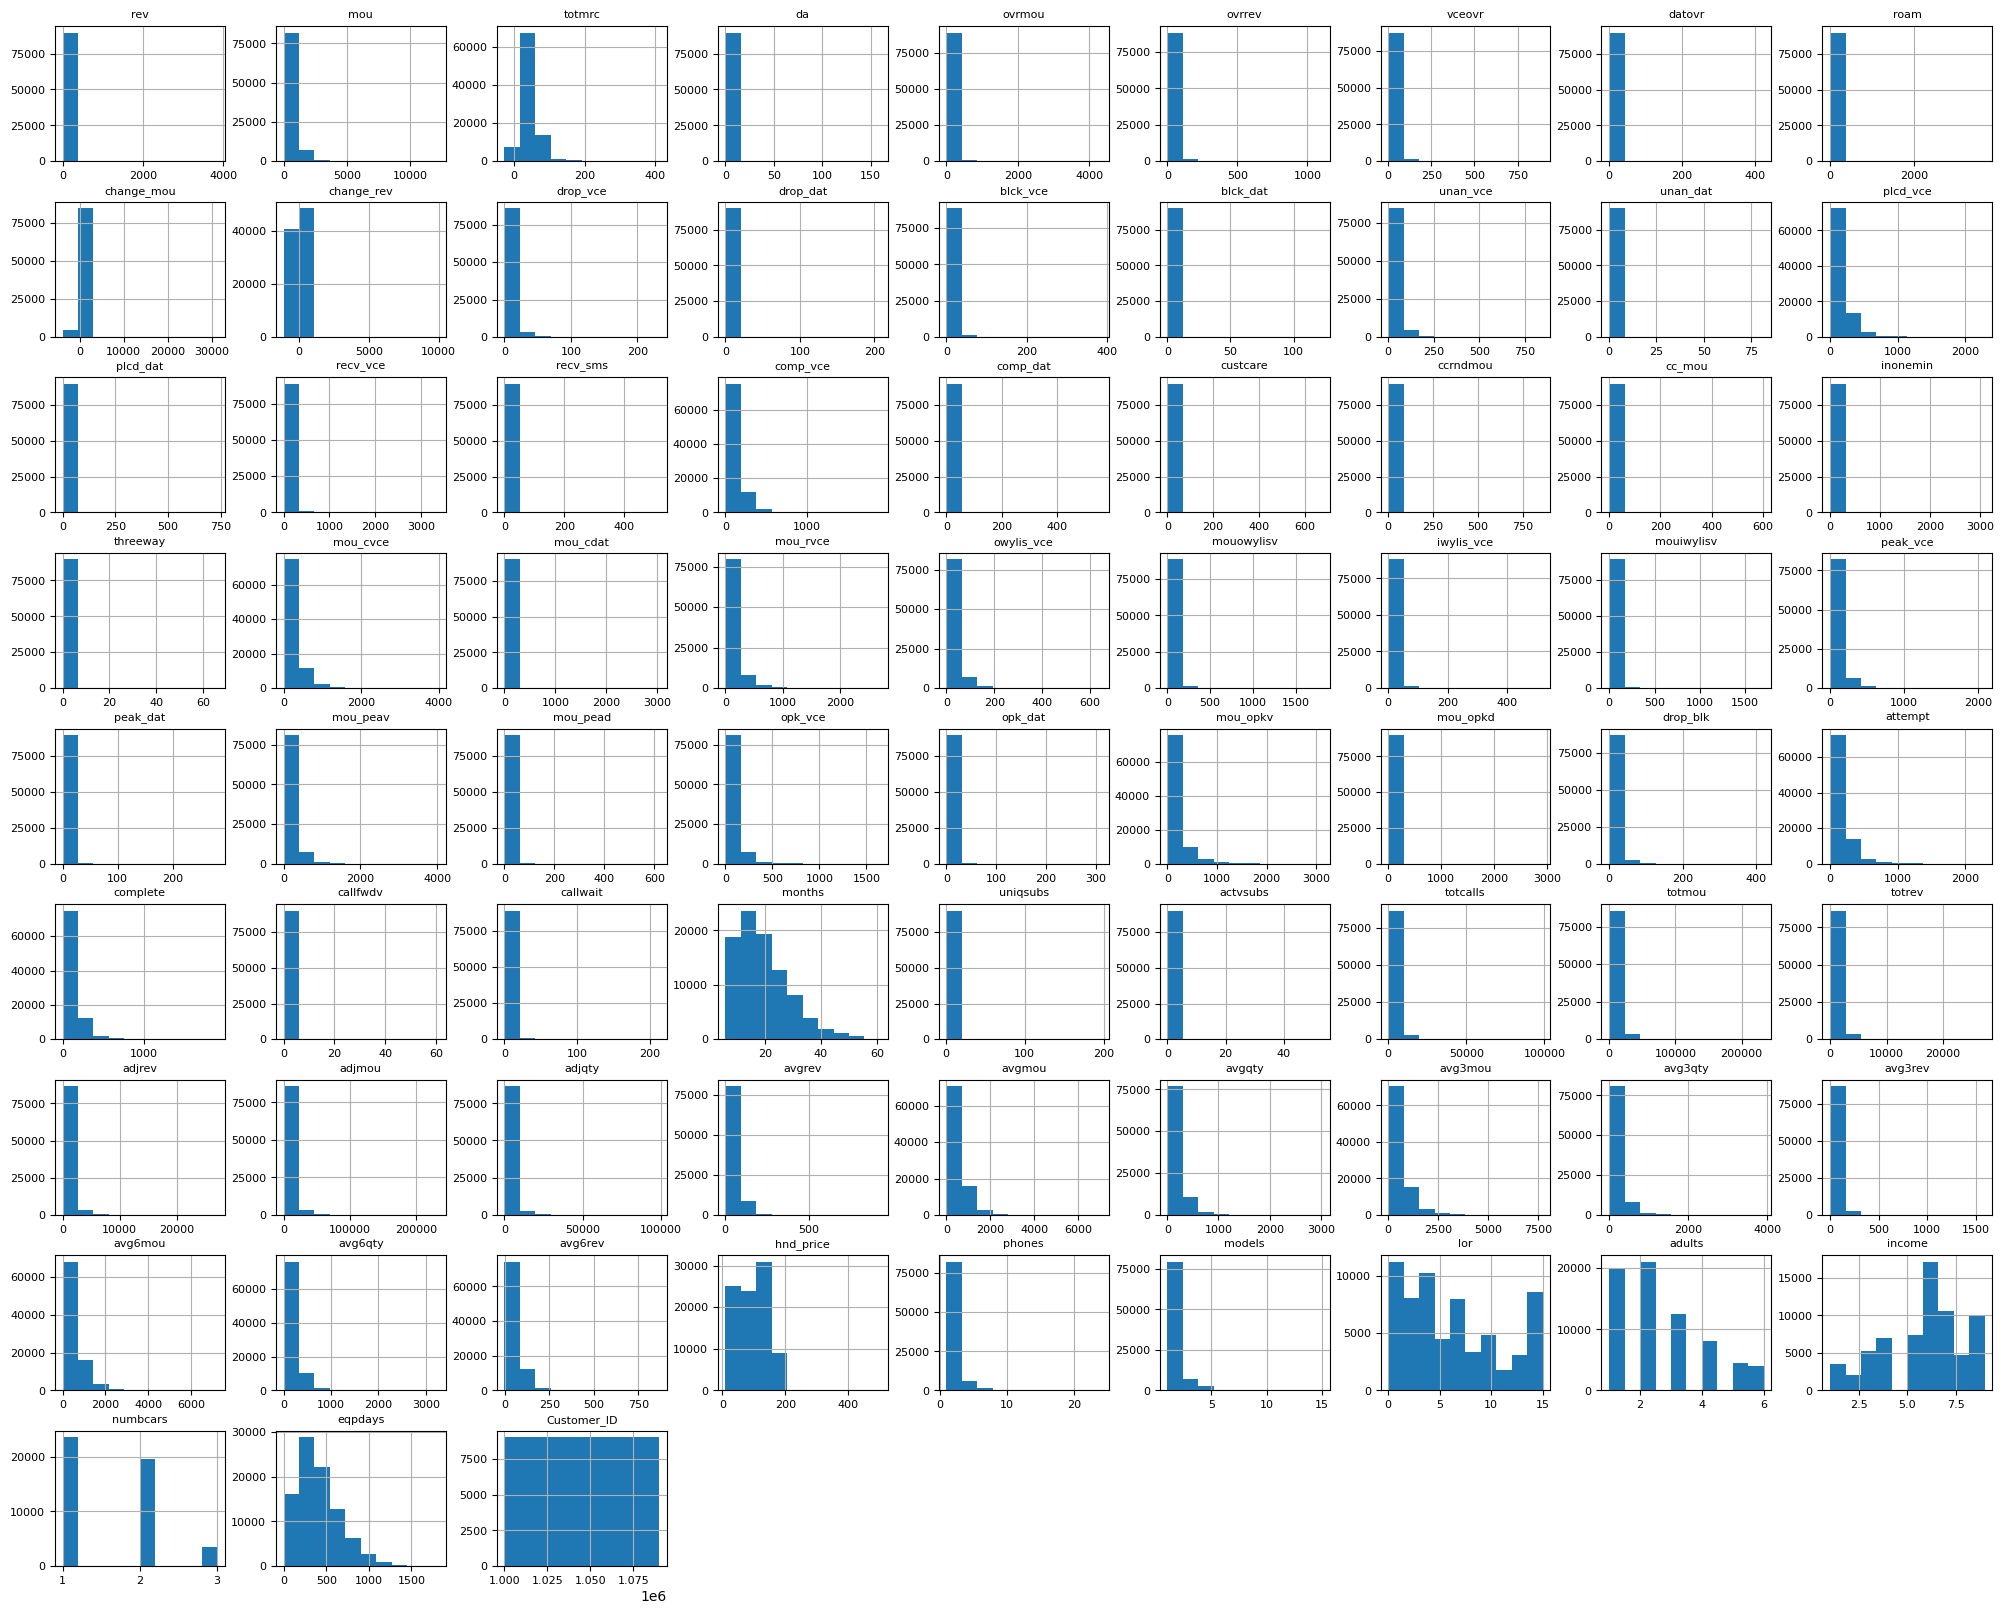

In [25]:
fig = df[lista_numericas].hist(figsize=(25,20), xlabelsize=8, ylabelsize=8);
[x.title.set_size(8) for x in fig.ravel()];

In [26]:
# las columnas rev, totmrc, change_mou, change_mou y avg6rev pueden tener valores negativos
# Número de días (antigüedad) del equipo actual o eqpdays no puede tener valores negativos por definición

# Seleccionar variables con valor mínimo negativo
df_negativos = df[lista_numericas].describe().loc[['min']] < 0

# Filtrar columnas con valores mínimos negativos
lista_columnas_negativos= df_negativos.columns[df_negativos.iloc[0]].tolist()

lista_columnas_negativos

['rev', 'totmrc', 'change_mou', 'change_rev', 'avg6rev', 'eqpdays']

In [27]:
df[df['eqpdays']<0]


,rev,mou,totmrc,da,ovrmou,ovrrev,vceovr,datovr,roam,change_mou,change_rev,drop_vce,drop_dat,blck_vce,blck_dat,unan_vce,unan_dat,plcd_vce,plcd_dat,recv_vce,recv_sms,comp_vce,comp_dat,custcare,ccrndmou,cc_mou,inonemin,threeway,mou_cvce,mou_cdat,mou_rvce,owylis_vce,mouowylisv,iwylis_vce,mouiwylisv,peak_vce,peak_dat,mou_peav,mou_pead,opk_vce,opk_dat,mou_opkv,mou_opkd,drop_blk,attempt,complete,callfwdv,callwait,churn,months,uniqsubs,actvsubs,new_cell,crclscod,asl_flag,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,prizm_social_one,area,dualband,refurb_new,hnd_price,phones,models,hnd_webcap,truck,rv,ownrent,lor,dwlltype,marital,adults,infobase,income,numbcars,HHstatin,dwllsize,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
190,180.2250,3559.00,149.9900,11.3850,99.00,14.8500,14.8500,0.0000,0.0000,-149.00,-11.3850,3.666667,0.000000,31.000000,0.000000,120.666667,0.000000,812.333333,0.000000,538.000000,0.000000,659.333333,0.000000,0.000000,0.000000,0.000000,216.000000,0.333333,1389.553333,0.000000,1543.686667,26.666667,28.740000,6.666667,15.643333,725.333333,0.000000,1750.716667,0.000000,468.666667,0.000000,1182.523333,0.000000,34.666667,812.333333,659.333333,0.000000,60.666667,1,55,3,2,N,B,N,32793,93695.00,8127.27,8002.52,93464.00,32640,156.91,1832.63,640.00,3609,1155,184,3323.0,1100.0,225.0,C,TENNESSEE AREA,N,R,NaN,10.0,5.0,WC,0.0,0.0,NaN,NaN,NaN,U,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Z,U,U,U,U,U,N,-3.0,1000191
573,81.2250,227.75,59.9900,1.2375,0.00,0.0000,0.0000,0.0000,0.0000,30.25,98.2350,1.333333,0.000000,0.666667,0.000000,5.000000,0.000000,61.666667,0.000000,5.000000,0.000000,54.666667,0.000000,0.000000,0.000000,0.000000,2.666667,0.000000,152.866667,0.000000,8.686667,2.666667,2.580000,0.000000,0.000000,46.333333,0.000000,133.906667,0.000000,13.333333,0.000000,27.646667,0.000000,2.000000,61.666667,54.666667,0.000000,0.333333,1,53,2,2,N,A,N,3611,10012.05,2945.30,2915.46,10012.05,3611,56.07,192.54,69.44,218,62,48,261.0,71.0,49.0,C,SOUTH FLORIDA AREA,U,N,NaN,4.0,4.0,UNKW,0.0,0.0,O,5.0,S,M,3.0,M,9.0,NaN,I,A,0.0,U,U,U,U,U,U,Y,-3.0,1000574
810,36.3400,247.25,29.9900,2.4750,7.25,2.9000,2.9000,0.0000,0.9750,153.75,14.1000,2.666667,0.000000,0.666667,0.000000,21.333333,0.000000,110.333333,0.000000,17.333333,0.000000,85.666667,0.000000,0.000000,0.000000,0.000000,12.333333,0.000000,109.986667,0.000000,14.013333,22.666667,25.343333,3.666667,6.636667,68.000000,0.000000,82.316667,0.000000,25.000000,0.000000,41.683333,0.000000,3.333333,110.333333,85.666667,0.000000,0.000000,0,52,1,1,U,A,N,4662,10969.08,2550.41,2338.98,10865.08,4610,47.73,221.74,94.08,196,92,32,168.0,83.0,32.0,T,NORTHWEST/ROCKY MOUNTAIN AREA,N,N,NaN,4.0,4.0,WC,0.0,0.0,O,1.0,S,M,3.0,M,6.0,2.0,NaN,A,0.0,S,U,U,U,U,U,Y,-1.0,1000811
1371,77.1625,413.25,70.0000,0.7425,0.00,0.0000,0.0000,0.0000,1.9200,208.75,-3.9125,3.000000,0.000000,0.000000,0.000000,12.000000,0.000000,139.666667,0.000000,36.000000,0.000000,125.333333,0.000000,0.666667,3.000000,2.416667,20.666667,0.000000,188.116667,0.000000,66.403333,42.000000,35.870000,6.333333,9.460000,107.666667,0.000000,190.760000,0.000000,39.666667,0.000000,63.760000,0.000000,3.000000,139.666667,125.333333,0.000000,0.000000,0,49,2,1,N,A,N,11479,25239.06,4092.76,4009.47,25096.04,11421,83.53,522.83,237.94,344,152,79,393.0,178.0,78.0,U,NEW YORK CITY AREA,Y,N,299.989990,9.0,5.0,WCMB,0.0,0.0,O,6.0,M,S,1.0,M,7.0,NaN,C,B,0.0,N,U,U,U,U,U,Y,-1.0,1001372
3631,45.5100,666.00,44.9900,0.0000,26.00,9.1000,9.1000,0.0000,0.3200,35.00,-9.2400,23.333333,0.000000,4.333333,0.000000,61.333333,0.000000,267.666667,0.000000,94.333333,0.000000,183.333333,0.000000,0.000000,0.000000,0.000000,61.000000,2.666667,310.170000,0.000000,136.103333,60.333333,102.523333,9.666667,28.560000,110.666667,0.000000,209.433333,0.000000,157.000000,0.000000,236.840000,0.000000,27.666667,267.666667,183.333333,0.000000,0.000000,0,41,2,2,U,B,N,10464,20160.00,2029.11,2007.82,20139.00,10450,50.20,503.48,2

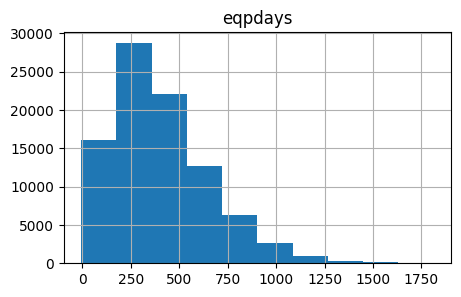

In [28]:
df['eqpdays'].hist(figsize=(5,3)).set_title('eqpdays');



*   **Análisis de variables categóricas**




In [29]:
# lista_categoricas
df[lista_categoricas].head(3)

,new_cell,crclscod,asl_flag,prizm_social_one,area,dualband,refurb_new,hnd_webcap,ownrent,dwlltype,marital,infobase,HHstatin,dwllsize,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd
0,U,A,N,S,NORTHWEST/ROCKY MOUNTAIN AREA,Y,N,WCMB,O,S,S,M,C,A,N,U,U,U,U,U,Y
1,N,EA,N,U,CHICAGO AREA,N,N,WC,NaN,S,S,M,C,A,Z,U,U,U,U,U,Y
2,Y,C,N,S,GREAT LAKES AREA,N,N,NaN,O,S,M,M,C,A,N,U,Y,U,U,U,Y


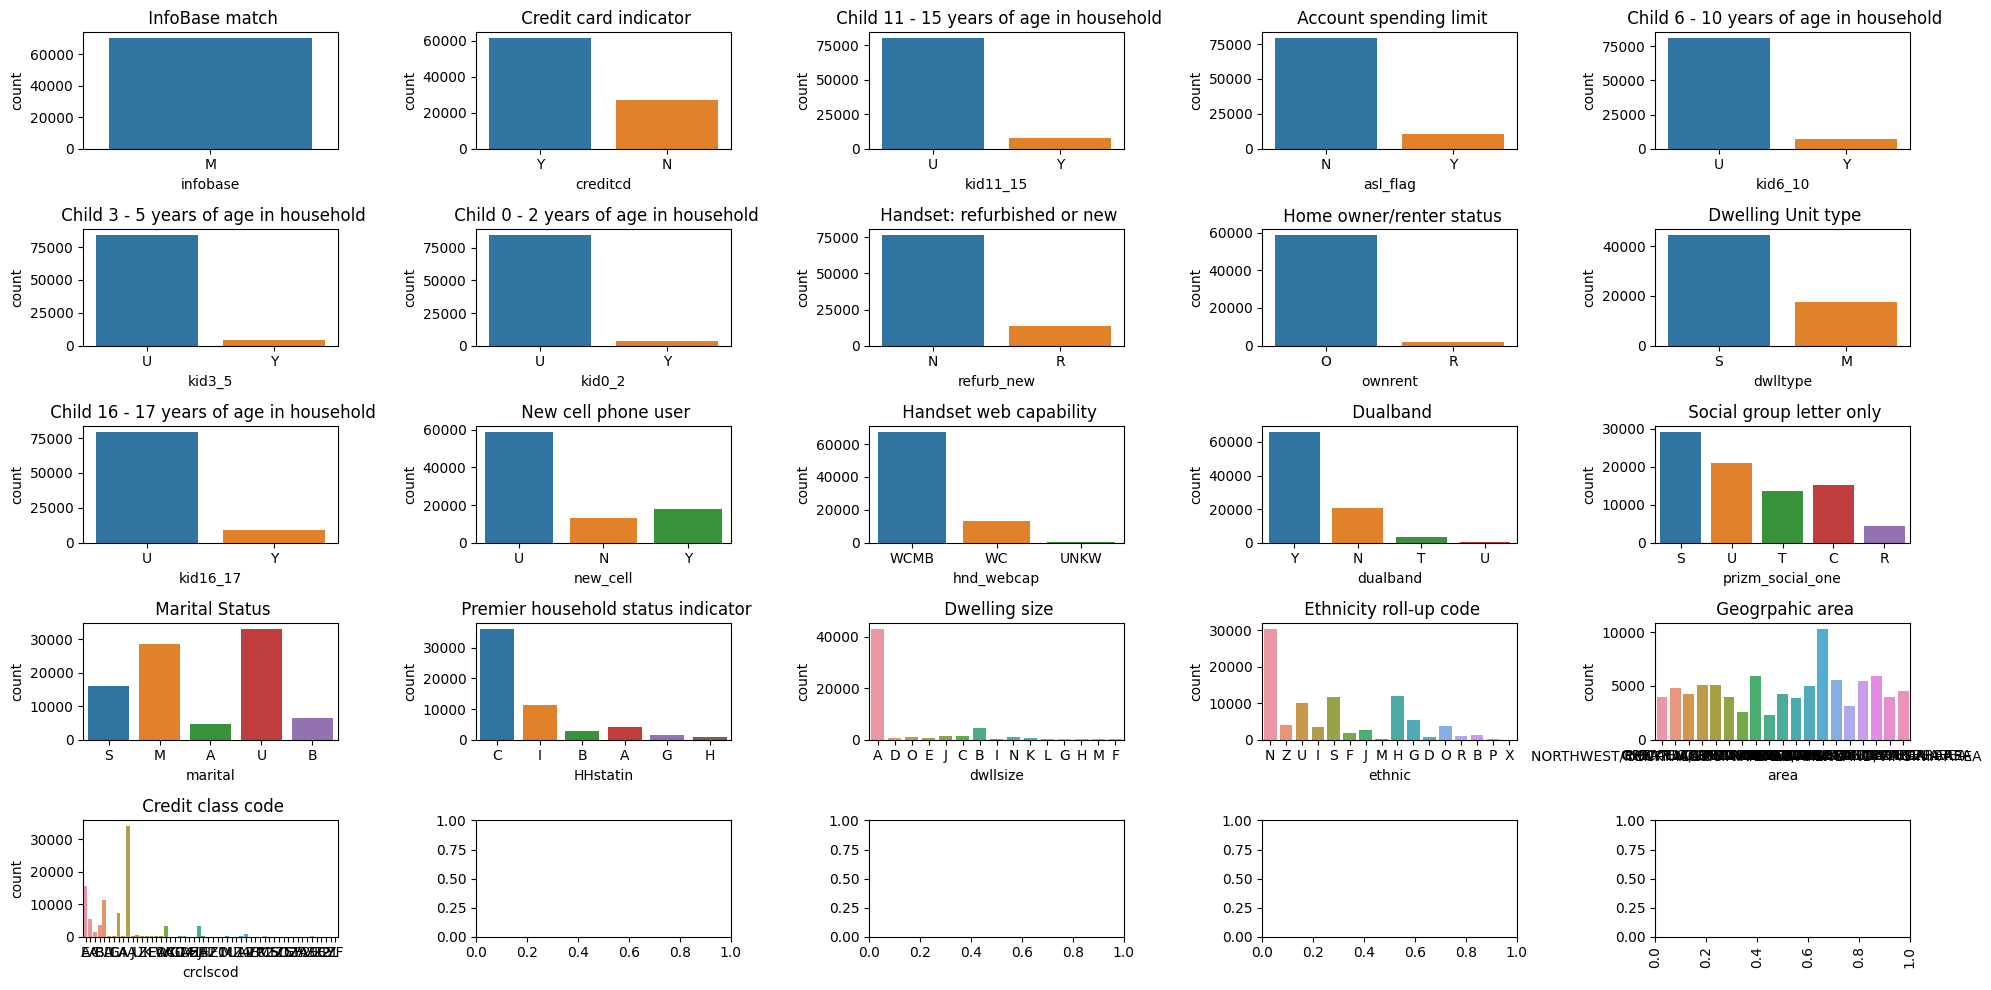

In [30]:
n_cols = 5
n_rows = math.ceil(len(lista_categoricas)/n_cols)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 10))
lista_categoricas_ord_unique = df[lista_categoricas].describe().T.sort_values(by="unique").index.to_list()

#data_show = df_churn[lista_categoricas]
data_show = df[lista_categoricas_ord_unique]

for i, col in enumerate(data_show):
    row_plot = i // n_cols
    col_plot = i % n_cols
    title_plot = df_desc[df_desc["Variable"]==col][" Description"].values[0]
    g = sns.countplot(x=col, data=data_show, ax=axes[row_plot,col_plot])
    g.set_title(title_plot)
    #g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right')


    plt.xticks(rotation=90)

    #for p in axes[row_plot,col_plot].patches:
    #    altura = p.get_height()

    #    axes[row_plot,col_plot].annotate(f'{altura /  100:.2f}%', (p.get_x() + p.get_width() / 2., altura),
    #            ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Ajustar o layout
plt.tight_layout()
plt.show()

**Análisis de variables booleanas**

In [31]:
#lista_num_binaria

df[lista_num_binaria].head(3)

,truck,rv,forgntvl
0,0.0,0.0,0.0
1,1.0,1.0,0.0
2,0.0,0.0,0.0


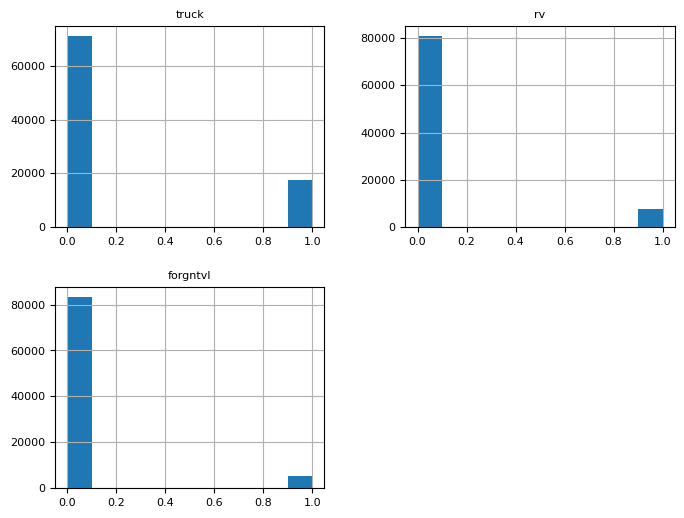

In [32]:
fig = df[lista_num_binaria].hist(figsize=(8,6), xlabelsize=8, ylabelsize=8);
[x.title.set_size(8) for x in fig.ravel()];

# Haremos una conversión posterior en int de 'truck','rv','forgntvl'

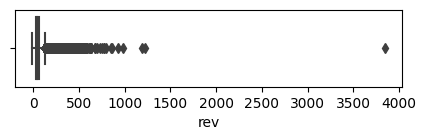

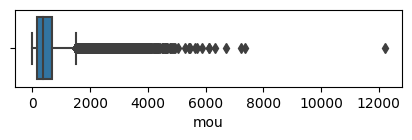

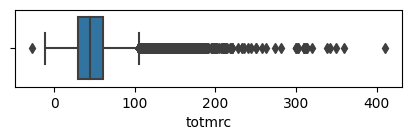

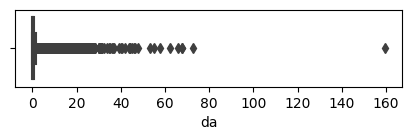

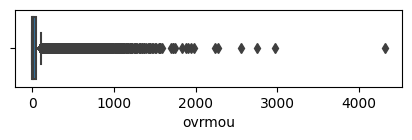

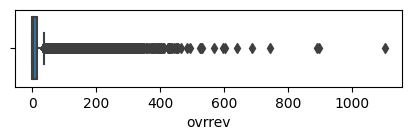

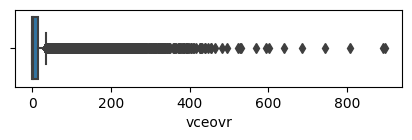

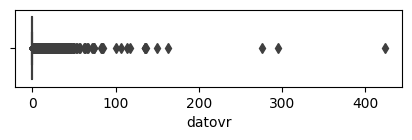

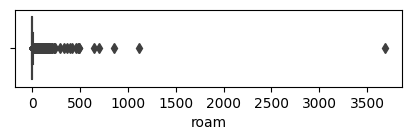

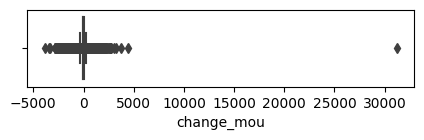

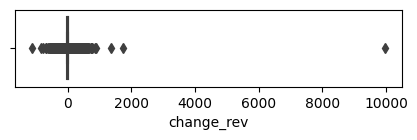

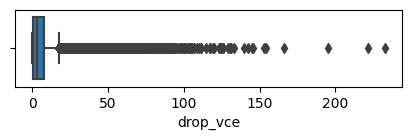

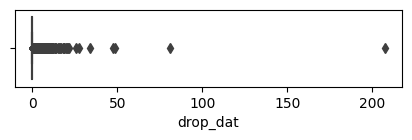

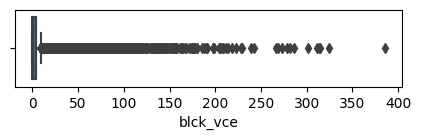

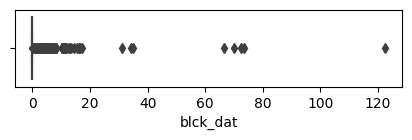

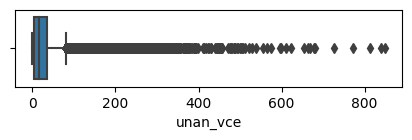

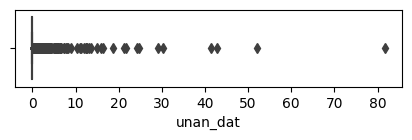

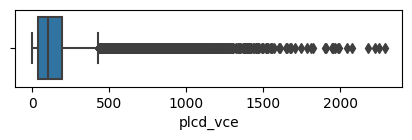

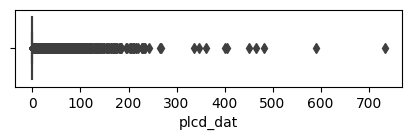

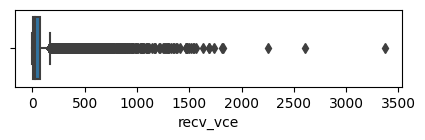

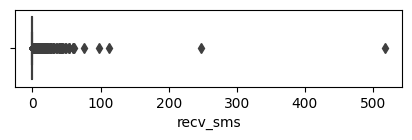

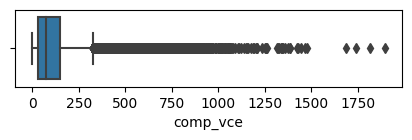

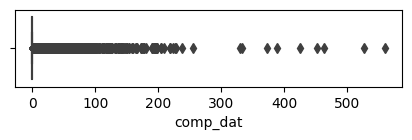

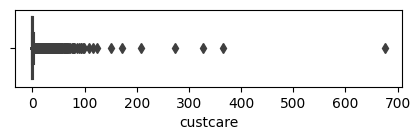

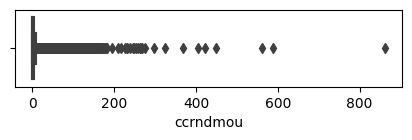

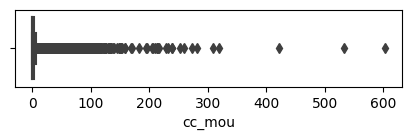

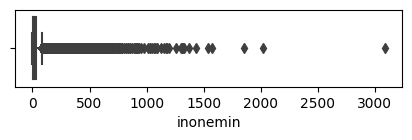

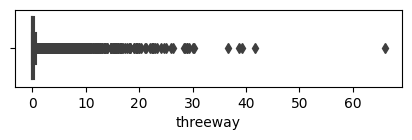

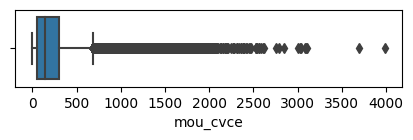

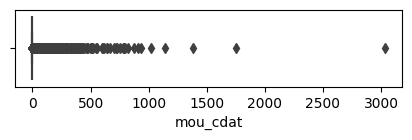

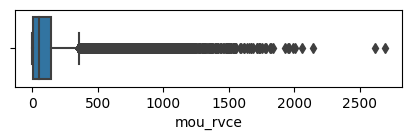

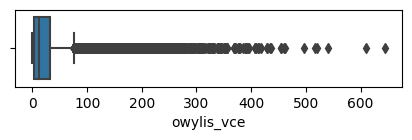

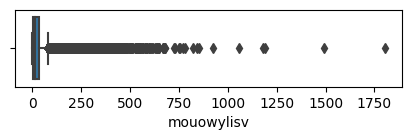

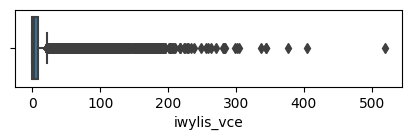

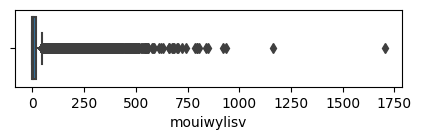

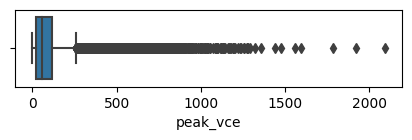

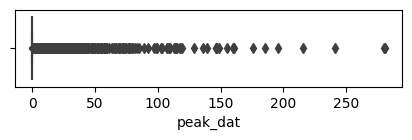

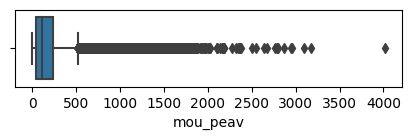

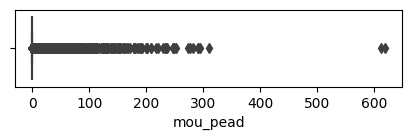

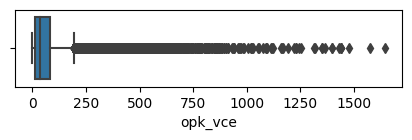

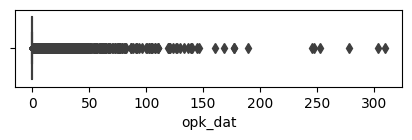

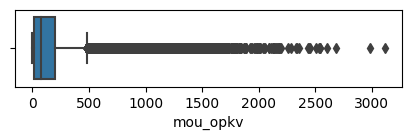

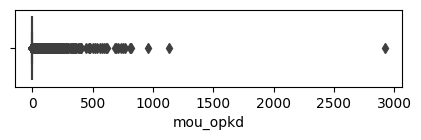

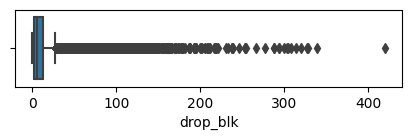

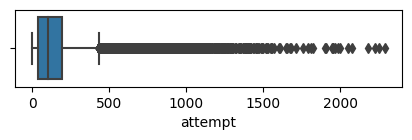

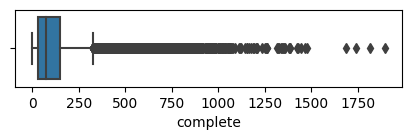

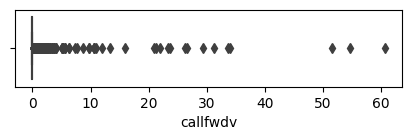

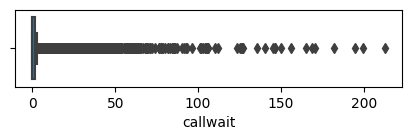

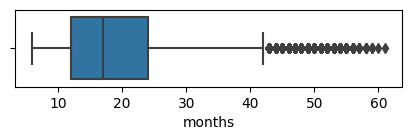

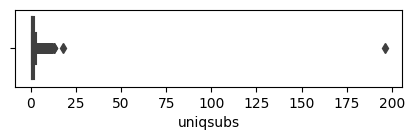

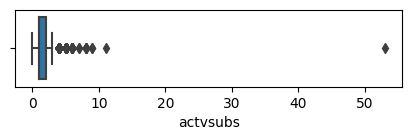

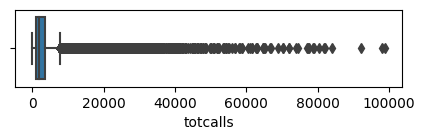

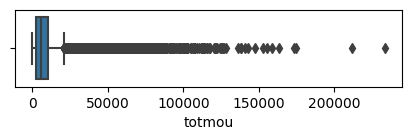

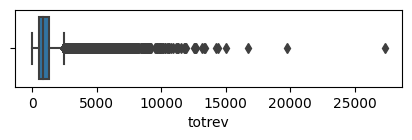

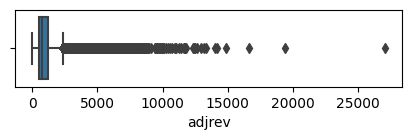

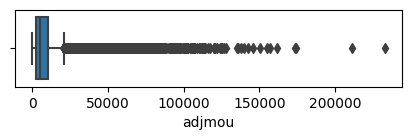

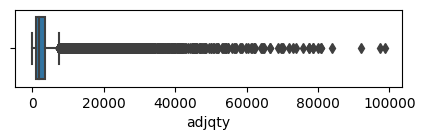

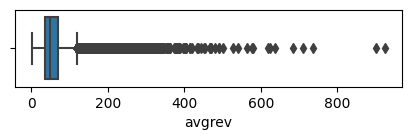

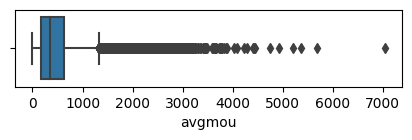

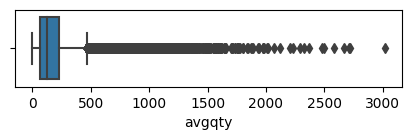

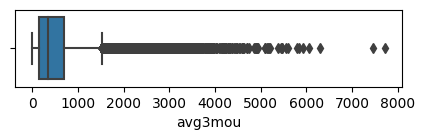

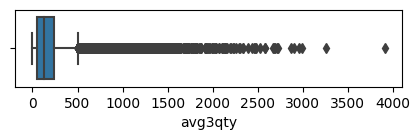

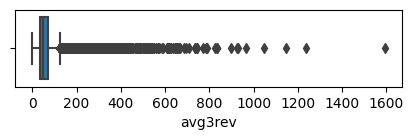

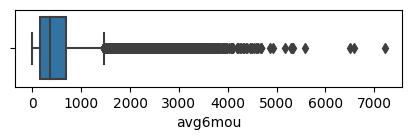

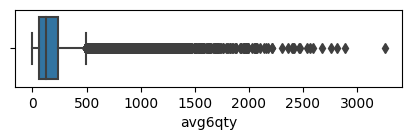

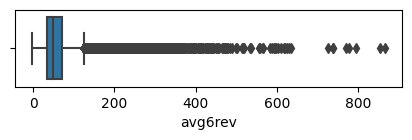

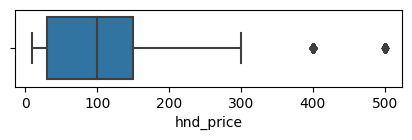

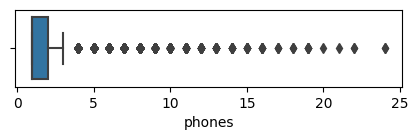

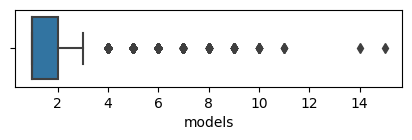

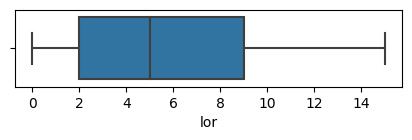

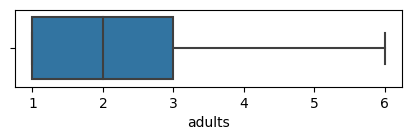

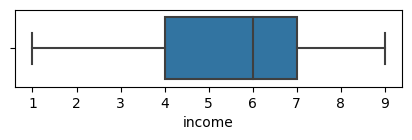

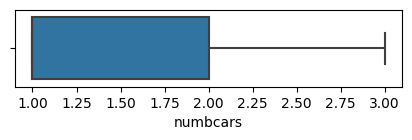

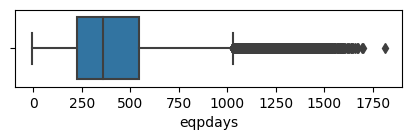

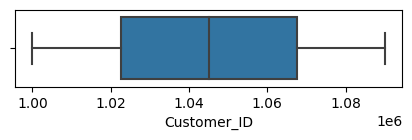

In [33]:
for i in lista_numericas:
    fig, axes = plt.subplots(figsize=(5,1))
    sns.boxplot(x = df[i])
    plt.show()

## Analisis Variable-Target

* Relacion target-variable

In [34]:
#Numéricas
n_cols = 3
n_rows = math.ceil(len(lista_numericas)/n_cols)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 120))
#lista_categoricas_ord_unique = df[lista_categoricas].describe().T.sort_values(by="unique").index.to_list()

#data_show = df[lista_categoricas]
data_show = df

for i, col in enumerate(lista_numericas):
    row_plot = i // n_cols
    col_plot = i % n_cols
    title_plot = df_desc[df_desc["Variable"]==col][" Description"].values[0]
    ax=axes[row_plot,col_plot]
    g = sns.kdeplot(data=data_show, x=col, hue="churn", ax=ax, fill=True, multiple="stack")
    g.set_title(title_plot)
    g.set_xticklabels(g.get_xticklabels(), rotation=90, ha='right')


# Ajustar o layout
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

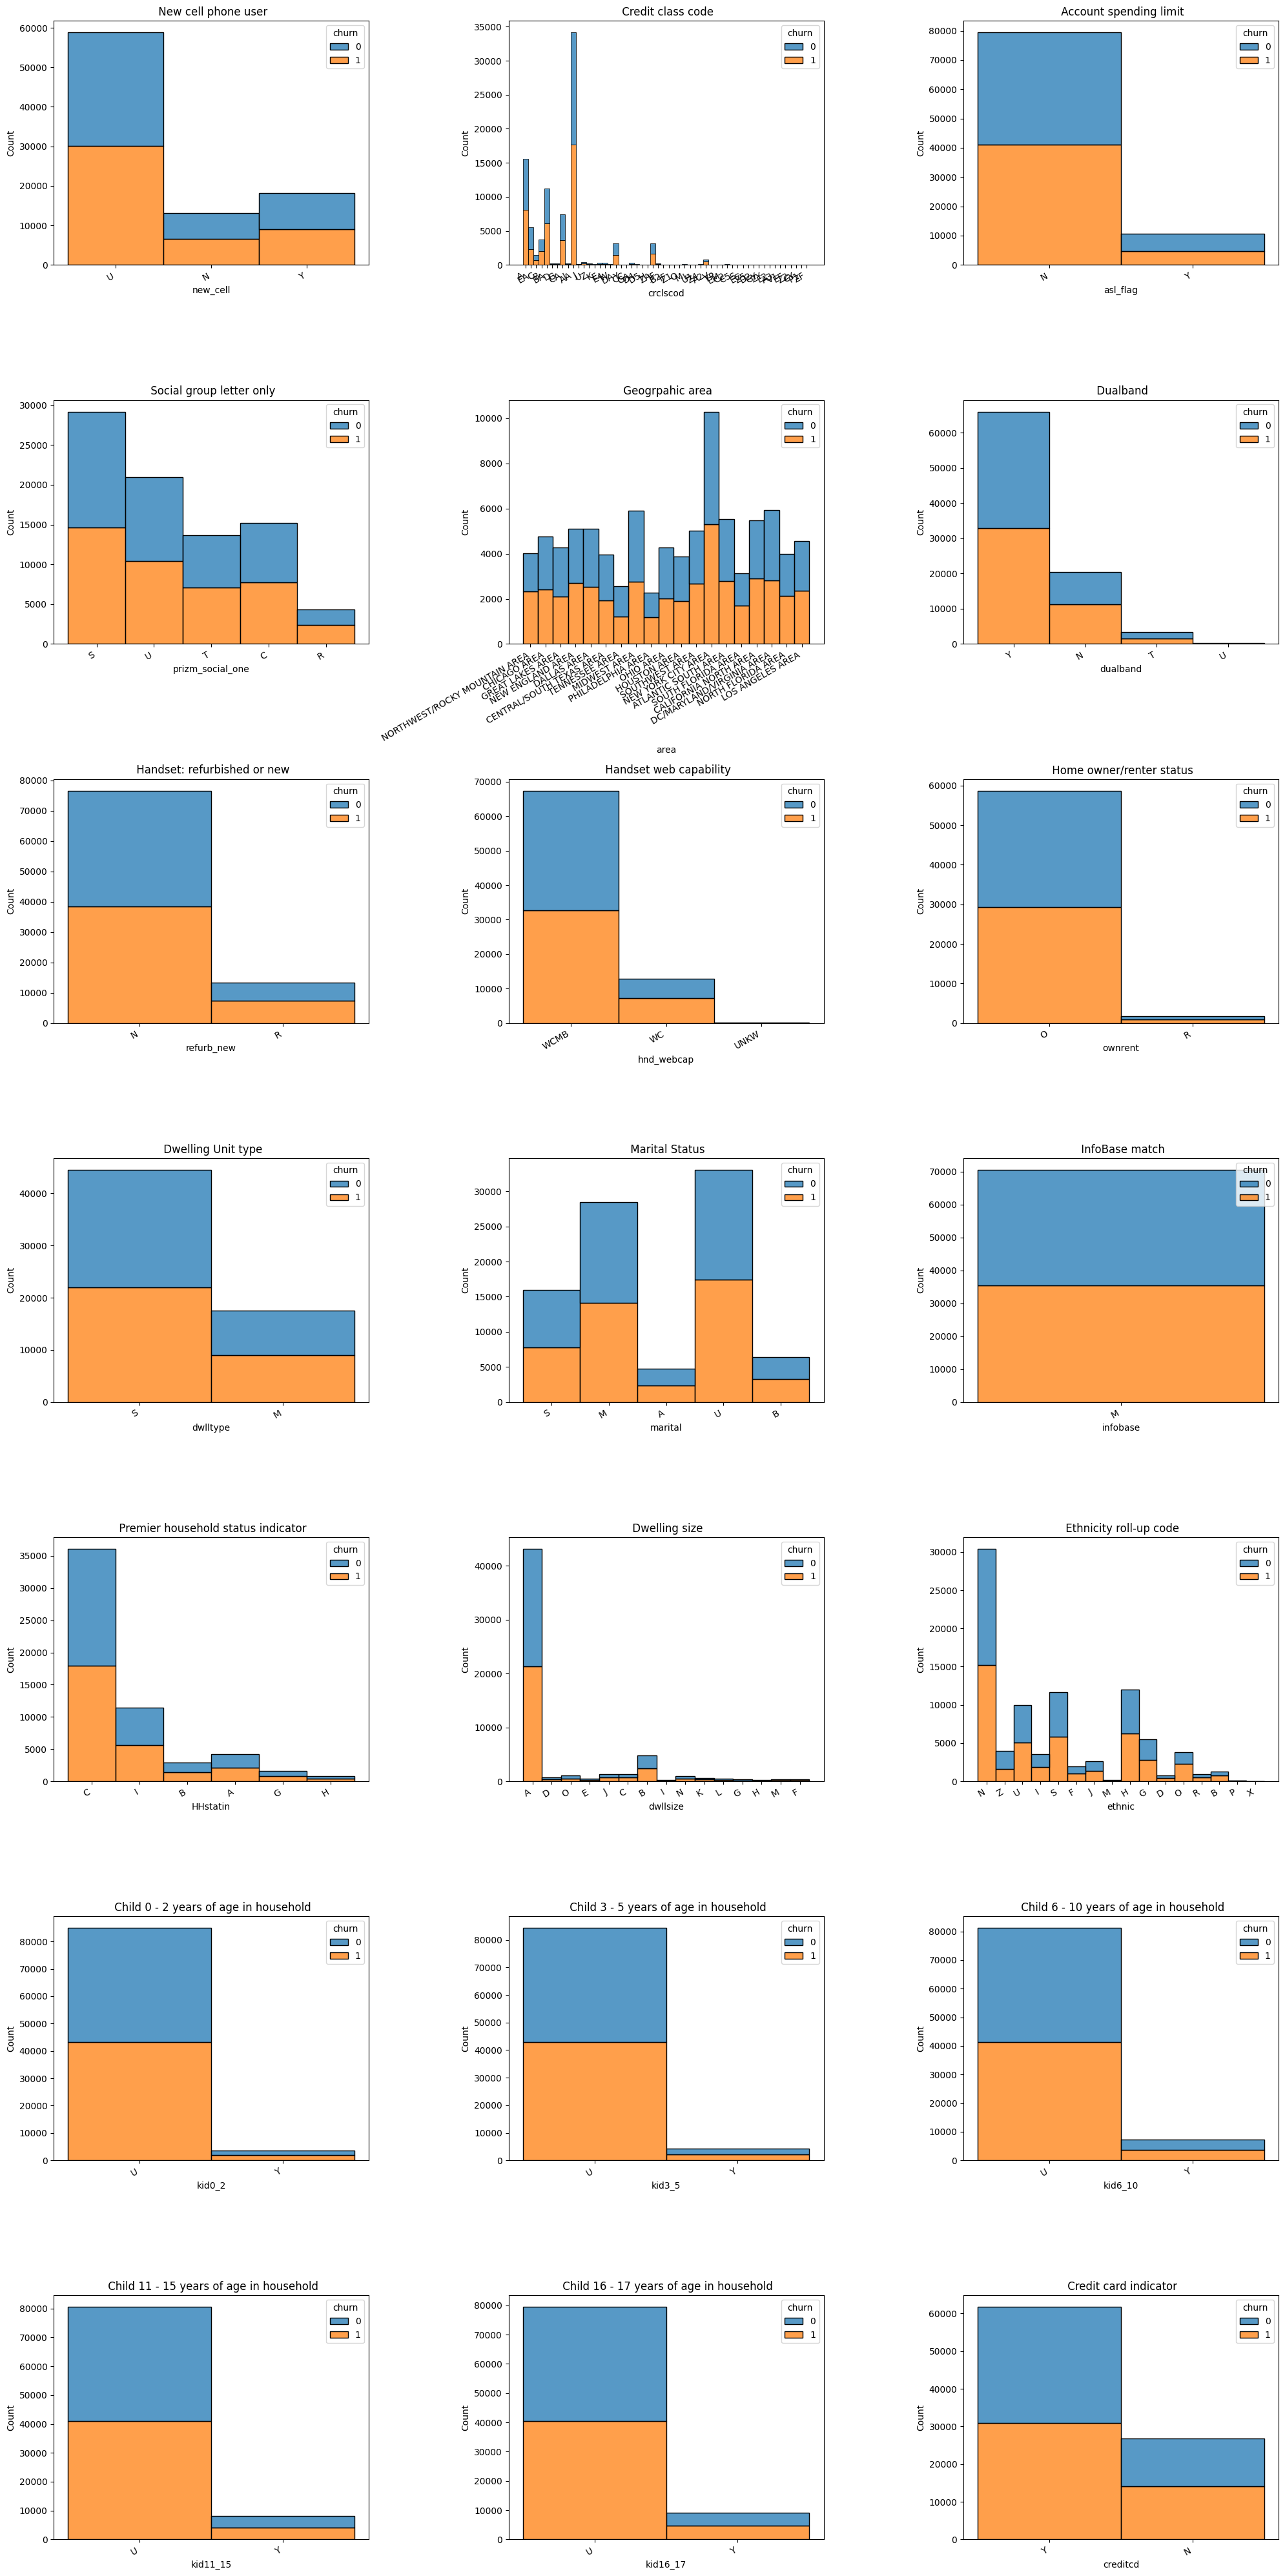

In [35]:
#Categoricas
n_cols = 3
n_rows = math.ceil(len(lista_categoricas)/n_cols)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 40))
#lista_categoricas_ord_unique = df[lista_categoricas].describe().T.sort_values(by="unique").index.to_list()

#data_show = df[lista_categoricas]
data_show = df

for i, col in enumerate(lista_categoricas):
    row_plot = i // n_cols
    col_plot = i % n_cols
    title_plot = df_desc[df_desc["Variable"]==col][" Description"].values[0]
    ax=axes[row_plot,col_plot]
    g = sns.histplot(data=data_show, x=col, hue="churn", ax=ax, multiple="stack")
    g.set_title(title_plot)
    g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='right')



    #for p in ax.patches:
     #       altura = p.get_height()
      #      ax.annotate(f'{altura:.0f}', (p.get_x() + p.get_width() / 2., altura),
       #                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Ajustar o layout
plt.tight_layout()
plt.show()

<Axes: xlabel='months', ylabel='churn'>

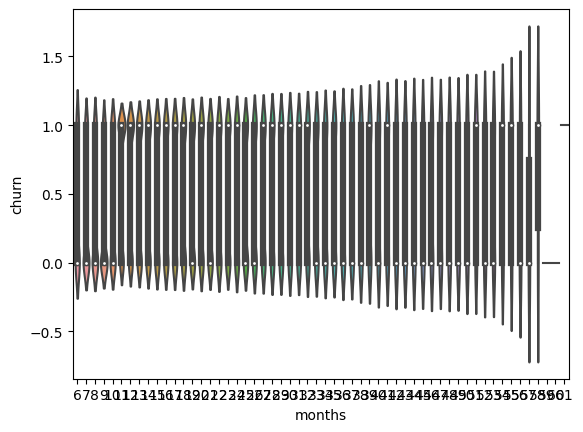

In [36]:
sns.violinplot(x="months", y="churn", data=df)

<Axes: xlabel='rev', ylabel='churn'>

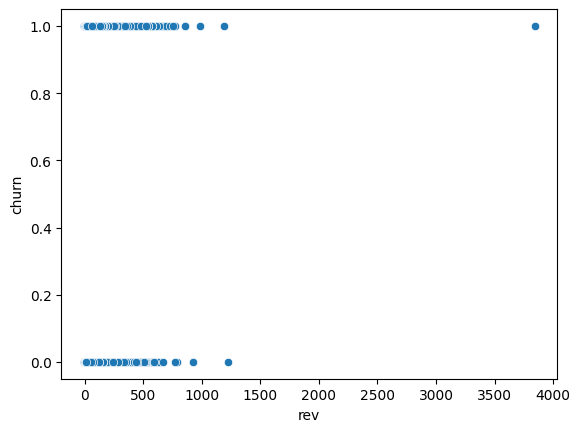

In [37]:
sns.scatterplot(x="rev", y="churn", data=df)

In [38]:
y.describe().T

count    90000.000000
mean         0.508889
std          0.499924
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: churn, dtype: float64

<Axes: xlabel='months', ylabel='Density'>

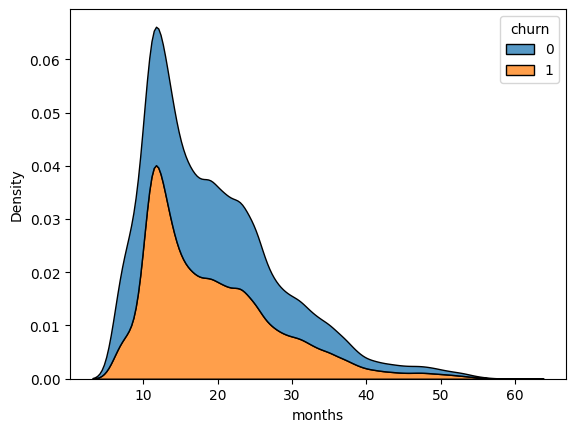

In [39]:
sns.kdeplot(data=df, x="months", hue="churn", multiple="stack")

# Data Cleaning

* Eliminar filas sin target informado.
* Eliminar filas duplicadas (si tenemos ID, solo puede haber 1 registro por ID)
* Eliminar filas/columnas vacías y columnas irrelevantes
* Corregir data types incorrectos
* Categoricos: Corregir literales incorrectos (acentos, erratas, etc)
* Fechas y textos: convertir a variables numericas (hour, day, month, year...) o categoricas (weekday_name...)

In [40]:
#Log o registro con las transformaciones aplicadas
df_log = pd.DataFrame(columns=["Variable", "Tipo", "Categoria", "Operacion"])

#Cópia de seguridad
df2 = df.copy()

- Eliminar filas sin target informado

In [41]:
# Check filas sin target informado
df2['churn'].isna().sum()

#No hay filas sin target informado a eliminar

0

- Eliminar filas duplicadas (si tenemos ID, solo puede haber 1 registro por ID)


In [42]:
# Verigicación de duplicados en la variable Customer_ID:

len(df['Customer_ID'].unique()) - len(df2)


0

In [43]:
df2.duplicated().sum()

#No hay filas duplicadas para "Customer_ID"

print(df.duplicated().sum(),'duplicated rows were deleted')
df.drop_duplicates(inplace=True)
print(df.shape)

# No hay filas o registros duplicados

# Check duplicados
len(df2.index.unique())==len(df2.index)

# No hay filas duplicadas

0 duplicated rows were deleted
(90000, 100)


True

- Eliminar filas/columnas vacías y columnas irrelevantes

In [44]:
# Eliminar filas/columnas vacías

print((df2.isna().sum(axis=1)==df.shape[1]).sum(),'all-empty rows were deleted')
df.dropna(axis=0, how='all',inplace=True)
print(df2.shape)

print(df['churn'].isna().sum(),'rows with null target were deleted')
df.dropna(subset=['churn'],inplace=True)

# No hay columnas vacías

0 all-empty rows were deleted
(90000, 100)
0 rows with null target were deleted


In [45]:
#Eliminar filas/columnas vacías y columnas irrelevantes

#La variable "infobase" solo aporta un valor "M" además de nulos (21,5%)
df_report = reportFeature(df2).filter(like="infobase", axis=0)
df_report

,Nulos,Porcentaje,Tipo,N_Unique,Unique(10)
infobase,19403,21.56,object,1.0,['M' nan]


In [46]:
#Eliminacion de la variable "infobase"
df2.drop(["infobase"], axis=1, inplace=True)


In [47]:
#verificacion
print("infobase" in df2.columns)

False


In [48]:
#Registrar LOG de la operación
category_operation = "Data Cleaning"
operation = "Eliminar filas/columnas vacías y columnas irrelevantes'"
logCleaningOperation(df_log, df_report, ["infobase"], category_operation, operation)

,Variable,Tipo,Categoria,Operacion
0,infobase,object,Data Cleaning,Eliminar filas/columnas vacías y columnas irrelevantes'


In [49]:
df_log

,Variable,Tipo,Categoria,Operacion
0,infobase,object,Data Cleaning,Eliminar filas/columnas vacías y columnas irrelevantes'


In [50]:
df_report

,Nulos,Porcentaje,Tipo,N_Unique,Unique(10)
infobase,19403,21.56,object,1.0,['M' nan]


- **Corregir data types incorrectos**

- **Análisis de conversión de variables de float a int**

In [51]:
df2.select_dtypes(include='integer').columns

Index(['churn', 'months', 'uniqsubs', 'actvsubs', 'totcalls', 'adjqty',
       'avg3mou', 'avg3qty', 'avg3rev', 'Customer_ID'],
      dtype='object')

In [52]:
df_desc[df_desc['Variable'].isin(['phones', 'models', 'truck', 'rv', 'lor', 'adults', 'income', 'numbcars', 'forgntvl', 'eqpdays'])]


,Variable,Description,Tipo
75,phones,Number of handsets issued,float64
76,models,Number of models issued,float64
78,truck,Truck indicator,float64
79,rv,RV indicator,float64
81,lor,Length of residence,float64
84,adults,Number of adults in household,float64
86,income,Estimated income,float64
87,numbcars,Known number of vehicles,float64
90,forgntvl,Foreign travel dummy variable,float64
98,eqpdays,Number of days (age) of current equipment,float64


In [53]:
# Conversión a int de las variables "rv", "forgntvl", "truck","phones","lor","numbcars","income","models","adults"

columnas_a_convertir = ["rv", "forgntvl", "truck","phones","lor","numbcars","income","models","adults","eqpdays"]

for i in columnas_a_convertir:
    df2[i] = df2[i].astype("Int64")

# Verificar los tipos de datos después de la conversión
print(df2[["rv", "forgntvl", "truck","phones","lor","numbcars","income","models","adults","eqpdays"]].dtypes)

rv          Int64
forgntvl    Int64
truck       Int64
phones      Int64
lor         Int64
numbcars    Int64
income      Int64
models      Int64
adults      Int64
eqpdays     Int64
dtype: object


In [55]:
# Función para registrar la operación en el log
def logOperation(log_df, category_operation, operation_description):
    log_df = log_df.append({
        'Category': category_operation,
        'Operation': operation_description
    }, ignore_index=True)
    return log_df

# Registro de la operación en el log
category_operation = "Data Transformation"
operation_description = "Conversión a tipo 'Int64' de las variables: 'rv', 'forgntvl', 'truck', 'phones', 'lor', 'numbcars', 'income', 'models', 'adults', 'eqpdays'"

df_log = logOperation(df_log, category_operation, operation_description)

In [56]:
df_log

,Variable,Tipo,Categoria,Operacion,Category,Operation
0,infobase,object,Data Cleaning,Eliminar filas/columnas vacías y columnas irrelevantes',NaN,NaN
1,NaN,NaN,NaN,NaN,Data Transformation,"Conversión a tipo 'Int64' de las variables: 'rv', 'forgntvl', 'truck', 'phones', 'lor', 'numbcar..."


- **Análisis de conversión de variables de int a float**





In [57]:
df2.select_dtypes(include='float').columns

Index(['rev', 'mou', 'totmrc', 'da', 'ovrmou', 'ovrrev', 'vceovr', 'datovr',
       'roam', 'change_mou', 'change_rev', 'drop_vce', 'drop_dat', 'blck_vce',
       'blck_dat', 'unan_vce', 'unan_dat', 'plcd_vce', 'plcd_dat', 'recv_vce',
       'recv_sms', 'comp_vce', 'comp_dat', 'custcare', 'ccrndmou', 'cc_mou',
       'inonemin', 'threeway', 'mou_cvce', 'mou_cdat', 'mou_rvce',
       'owylis_vce', 'mouowylisv', 'iwylis_vce', 'mouiwylisv', 'peak_vce',
       'peak_dat', 'mou_peav', 'mou_pead', 'opk_vce', 'opk_dat', 'mou_opkv',
       'mou_opkd', 'drop_blk', 'attempt', 'complete', 'callfwdv', 'callwait',
       'totmou', 'totrev', 'adjrev', 'adjmou', 'avgrev', 'avgmou', 'avgqty',
       'avg6mou', 'avg6qty', 'avg6rev', 'hnd_price'],
      dtype='object')

In [58]:
# Variables con posible conversión a float

# las variables avg3mou, avg3qty y avg3rev representan promedios de llamadas y facturamento como "int64", mientras que
# sus equivalentes de promedio de los ultimos 6 meses y promedio de por vida son representadas como "float64".

reportFeature(df2).filter(like='avg', axis=0)

,Nulos,Porcentaje,Tipo,N_Unique,Unique(10)
avg6rev,1407,1.56,float64,442.0,[38. 48. 17. 40. 80. 78. 58. 90. 34. 64.]
avg6qty,1407,1.56,float64,1342.0,[136. 275. 6. 25. 196. 853. 0. 112. 434. 7.]
avg6mou,1407,1.56,float64,2871.0,[ 322. 477. 11. 50. 586. 1187. 0. 719. 915. 54.]
avgrev,0,0.00,float64,14194.0,[29.66 51.53 34.54 40.45 38.69 83.68 58.95 34.71 81.39 26.51]
avgmou,0,0.00,float64,54496.0,[ 83.37 479.4 433.98 63.23 249.38 857.34 334.06 303.39 810.25 17.75]
avgqty,0,0.00,float64,33312.0,[ 32.69 265.89 140.86 30.81 79.5 560.89 120.6 109.02 312.81 6.85]
avg3mou,0,0.00,int64,3018.0,[ 272 305 12 8 558 1260 0 633 973 6]
avg3qty,0,0.00,int64,1401.0,[116 158 7 3 191 960 0 96 465 16]
avg3rev,0,0.00,int64,494.0,[30 40 17 38 55 80 39 90 60 36]


- **Análisis de conversión de variables de float a int**

In [59]:
# las siguientes columnas se deben cambiar a float

columns_to_change_to_float = ['avg3mou', 'avg3qty', 'avg3rev']

for i in columns_to_change_to_float:

    df2[i] =  df2[i].astype('float')

In [64]:
# Función para registrar la operación en el log
def logCleaningOperation(log_df, columns_changed, category_operation, operation_description):
    for col in columns_changed:
        log_df = log_df.append({
            'Column': col,
            'Operation': operation_description,
            'Category': category_operation
        }, ignore_index=True)
    return log_df

# Columnas que se deben cambiar a tipo 'float'
columns_to_change_to_float = ['avg3mou', 'avg3qty', 'avg3rev']

# Cambiar el tipo de las columnas a 'float'
for col in columns_to_change_to_float:
    df2[col] = df2[col].astype('float')

# Registrar la operación en el log
category_operation = "Data Cleaning"
operation_description = "Cambio de tipo de las columnas a 'float'"
df_log = logCleaningOperation(df_log, columns_to_change_to_float, category_operation, operation_description)

In [65]:
df_log

,Variable,Tipo,Categoria,Operacion,Category,Operation,Column
0,infobase,object,Data Cleaning,Eliminar filas/columnas vacías y columnas irrelevantes',NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,Data Transformation,"Conversión a tipo 'Int64' de las variables: 'rv', 'forgntvl', 'truck', 'phones', 'lor', 'numbcar...",NaN
2,NaN,NaN,NaN,NaN,Data Cleaning,Cambio de tipo de las columnas a 'float',avg3mou
3,NaN,NaN,NaN,NaN,Data Cleaning,Cambio de tipo de las columnas a 'float',avg3qty
4,NaN,NaN,NaN,NaN,Data Cleaning,Cambio de tipo de las columnas a 'float',avg3rev


In [66]:
# Verificación

reportFeature(df2).filter(like='avg', axis=0)

,Nulos,Porcentaje,Tipo,N_Unique,Unique(10)
avg6rev,1407,1.56,float64,442.0,[38. 48. 17. 40. 80. 78. 58. 90. 34. 64.]
avg6qty,1407,1.56,float64,1342.0,[136. 275. 6. 25. 196. 853. 0. 112. 434. 7.]
avg6mou,1407,1.56,float64,2871.0,[ 322. 477. 11. 50. 586. 1187. 0. 719. 915. 54.]
avgrev,0,0.00,float64,14194.0,[29.66 51.53 34.54 40.45 38.69 83.68 58.95 34.71 81.39 26.51]
avgmou,0,0.00,float64,54496.0,[ 83.37 479.4 433.98 63.23 249.38 857.34 334.06 303.39 810.25 17.75]
avgqty,0,0.00,float64,33312.0,[ 32.69 265.89 140.86 30.81 79.5 560.89 120.6 109.02 312.81 6.85]
avg3mou,0,0.00,float64,3018.0,[ 272. 305. 12. 8. 558. 1260. 0. 633. 973. 6.]
avg3qty,0,0.00,float64,1401.0,[116. 158. 7. 3. 191. 960. 0. 96. 465. 16.]
avg3rev,0,0.00,float64,494.0,[30. 40. 17. 38. 55. 80. 39. 90. 60. 36.]


- **Análisis del resto de variables numéricas**

Dudas
(1) "avg6rev" indica el promedio de ingresos en los últimos 6 meses. Valores negativos podrían indicar ausencia de pago (débito) para el período.
Sin embargo, el concepto de ingreso(revenue) en el problema trata solo de valores efectivamente ingresados o incluso de valores que deberían ingresar(débitos)? Si tratar de la 2ª opción, es posible valores negativos, caso contrário no. Por lo tanto:

PREGUNTA: Cual es el concepto de ingreso "revenue" para el problema? Son admisibles valores negativos para médias por período?

(2) "change_mou" y (3) "change_rev" representan variaciones en % de uso o ingresos. Valores negativos indican caída en en uso de servicios/ingreso en el período. Pero, tecnicamente:
PREGUNTA: Es um problema para el modelo manejar numeros negativos?

(4) "epqdays" represeta la edad, en dias, del equipamento. Por lo tanto, en teoría, no puede contener valores negativos. De todo modo:
PREGUNTA: Hay algun significado en valores negativos para "epadays" ?

(5) "rev" corresponde a la media de ingresos por valores efectivamente cobrados. Por lo tanto, no haría sentido aportar valores negativos, ya que han sido cobrados.
PREGUNTA: La premisa es correcta? Hay algun sentido la variable aportar valores negativos?

(6) "totmrc" corresponde a la media total de cobros recurrentes. Por lo tanto, no haría sentido aportar valores negativos, ya que no es posible cobrar algo "que no se cobró". A menos que, quizás, representase el intento de devolver algo cobrado indevidamente.
PREGUNTA: La premisa es correcta? Hay algun sentido la variable aportar valores negativos?

In [67]:
# Variable change_mou o  variación porcentual de los minutos de uso mensuales frente a la media de los tres meses anteriores

df_desc[df_desc['Variable'].isin(['change_mou'])]

,Variable,Description,Tipo
9,change_mou,Percentage change in monthly minutes of use vs previous three month average,float64


In [68]:
df2["change_mou"].describe()

count    89405.000000
mean       -13.786987
std        271.624916
min      -3875.000000
25%        -85.750000
50%         -6.500000
75%         61.250000
max      31219.250000
Name: change_mou, dtype: float64

In [69]:
# hace sentido una variable con valores de media con redondeo como float?
reportFeature(df2).filter(like="change_mou", axis=0)

,Nulos,Porcentaje,Tipo,N_Unique,Unique(10)
change_mou,595,0.66,float64,7127.0,[-157.25 532.25 -4.25 -1.5 38.5 156.75 0. 147.5 198.\n 59.5 ]


In [70]:
# Variable change_rev o Variación porcentual de los ingresos mensuales frente a la media de los tres meses anteriores

df_desc[df_desc['Variable'].isin(['change_rev'])]

,Variable,Description,Tipo
10,change_rev,Percentage change in monthly revenue vs previous three month average,float64


In [71]:
df2["change_rev"].describe()

count    89405.000000
mean        -1.074666
std         50.565668
min      -1107.740000
25%         -7.212500
50%         -0.315000
75%          1.537500
max       9963.657500
Name: change_rev, dtype: float64

In [72]:
reportFeature(df2).filter(like="change_rev", axis=0)

,Nulos,Porcentaje,Tipo,N_Unique,Unique(10)
change_rev,595,0.66,float64,30091.0,[-18.9975 50.9875 0. 8.145 -0.155 -3.0625 23.2625 4.0275\n 6.8225 -0.315 ]


- **Variables numéricas con valor negativo**

In [73]:
# Valores numéricos < 0
var_desc(df_stat[df_stat["min"]<0].index)

,Variable,Description,Tipo
0,rev,Mean monthly revenue (charge amount),float64
2,totmrc,Mean total monthly recurring charge,float64
9,change_mou,Percentage change in monthly minutes of use vs previous three month average,float64
10,change_rev,Percentage change in monthly revenue vs previous three month average,float64
69,avg6rev,Average monthly revenue over the previous six months,float64
98,eqpdays,Number of days (age) of current equipment,float64


Tener valores negativos en variables como "rev" (ingresos mensuales promedio), "totmrc" (cargo mensual recurrente total promedio) y otras relacionadas con ingresos o cargos podría tener sentido por varias razones:

- Reembolsos o Descuentos: Los reembolsos, descuentos o ajustes de crédito pueden resultar en valores negativos en ingresos mensuales o cargos recurrentes si se restan de los montos totales.

- Reducciones o Cancelaciones de Servicio: Si un cliente reduce o cancela servicios a mitad de un período facturado, puede generar valores negativos al ajustar los ingresos o cargos correspondientes a ese período.

- Errores o Datos Anómalos: A veces, los valores negativos pueden ser el resultado de errores en la recopilación o registro de datos, como registros incorrectos o anómalos.

En cuanto a las variables como "change_mou" (cambio porcentual en minutos de uso mensual) o "change_rev" (cambio porcentual en ingresos mensuales), un valor negativo podría indicar una disminución en comparación con el promedio de los tres meses anteriores. Es decir, si el valor es negativo, puede significar que hay una disminución en el uso de minutos o en los ingresos respecto al promedio de los tres meses previos.

En el contexto de "**avg6rev**" (ingreso promedio mensual durante los últimos seis meses), la presencia de valores negativos podría ser inusual o indicar posibles problemas en los datos, especialmente si se espera que represente un promedio de ingresos mensuales.

l campo "**eqpdays**" representa el número de días (edad) del equipo actual. Es posible que la presencia de valores negativos en esta variable sea inusual o sea indicativa de un problema en los datos.

En teoría, la edad de un equipo no puede ser negativa, ya que representa el tiempo transcurrido desde una fecha de inicio o activación.

In [74]:
# Filas en las que el valor en la columna "avg6rev" es menor que cero

df2[df2["avg6rev"]<0].filter(like="rev", axis=1).sort_index(axis=1)

,adjrev,avg3rev,avg6rev,avgrev,change_rev,ovrrev,rev,totrev
19095,841.49,5.0,-1.0,36.59,0.0000,0.0,5.0000,928.59
49741,577.61,5.0,-1.0,36.10,74.4975,0.0,29.8325,657.59
61909,269.29,5.0,-2.0,24.48,0.0000,0.0,5.0000,329.27


In [ ]:
# Filas en las que el valor en la columna "rev" es menor que cero

df2[df2["rev"]<0].filter(like="rev", axis=1).sort_index(axis=1)


In [77]:
# Filas en las que el valor en la columna "eqpdays" es menor que cero

df2[df2["eqpdays"]<0].filter(like="rev", axis=1)

,rev,ovrrev,change_rev,totrev,adjrev,avgrev,avg3rev,avg6rev
190,180.2250,14.8500,-11.3850,8127.27,8002.52,156.91,184.0,225.0
573,81.2250,0.0000,98.2350,2945.30,2915.46,56.07,48.0,49.0
810,36.3400,2.9000,14.1000,2550.41,2338.98,47.73,32.0,32.0
1371,77.1625,0.0000,-3.9125,4092.76,4009.47,83.53,79.0,78.0
3631,45.5100,9.1000,-9.2400,2029.11,2007.82,50.20,49.0,51.0
4134,95.3500,11.4950,-14.1200,3854.24,3823.25,98.03,100.0,205.0
4191,88.9800,0.0000,0.0000,1304.05,1196.46,85.46,5.0,42.0
7581,62.1725,0.0000,-3.4925,3788.54,3522.17,103.59,63.0,87.0
7663,71.6025,7.1175,56.8975,2750.11,2690.53,76.87,53.0,103.0
7976,45.6400,0.1750,12.4400,2338.79,2289.57,65.42,42.0,43.0


In [ ]:
# En teoría, la edad de un equipo no puede ser negativa,
# ya que representa el tiempo transcurrido desde una fecha de inicio o activación.

df2['eqpdays'].hist();

-3    32
-1    27
-2    26
-4    12
-5     5
Name: eqpdays, dtype: Int64

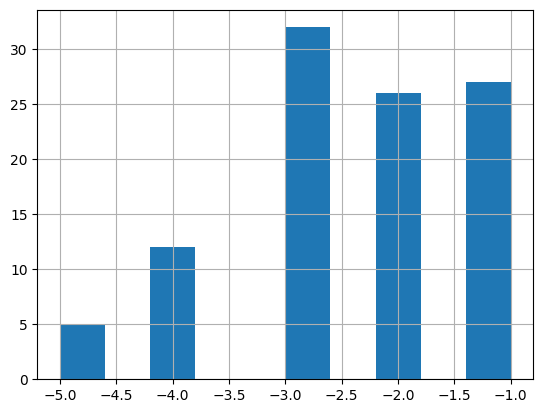

In [78]:
df_eqp_days_less_than_zero = df2[df2['eqpdays']<0]

df_eqp_days_less_than_zero['eqpdays'].hist();

df_eqp_days_less_than_zero['eqpdays'].value_counts()

In [80]:
# En estos valores negativos, se considera un error de medición,
# reemplazamos por la moda (la variable no tiene una distribución normal)

# Reemplazo de valores negativos por la moda de 'eqpdays'

# Función para registrar la operación en el log
def logReplacementOperation(log_df, column_name, category_operation, operation_description):
    log_df = log_df.append({
        'Column': column_name,
        'Operation': operation_description,
        'Category': category_operation
    }, ignore_index=True)
    return log_df

# Reemplazo de valores negativos por la moda de 'eqpdays'
df_eqp_days_less_than_zero = df2['eqpdays'] < 0
df_eqp_days_not_na = df2['eqpdays'].notna()
mode_eqpdays = df2['eqpdays'].mode()[0]

# Reemplazo de valores negativos por la moda de 'eqpdays'
df2.loc[df_eqp_days_less_than_zero & df_eqp_days_not_na, 'eqpdays'] = mode_eqpdays

# Registro de la operación en el log
category_operation = "Data Cleaning"
operation_description = "Reemplazo de valores negativos por la moda de 'eqpdays'"
df_log = logReplacementOperation(df_log, 'eqpdays', category_operation, operation_description)

In [88]:
# Verificación de valores negativos en la columna 'eqpdays'
negative_eqpdays = (df2['eqpdays'] < 0).any()

if negative_eqpdays:
    print("Se encontraron valores negativos en la columna 'eqpdays'")
else:
    print("No se encontraron valores negativos en la columna 'eqpdays'")

No se encontraron valores negativos en la columna 'eqpdays'


In [81]:
# check

df2.select_dtypes(include='int').columns

Index(['churn', 'months', 'uniqsubs', 'actvsubs', 'totcalls', 'adjqty',
       'phones', 'models', 'truck', 'rv', 'lor', 'adults', 'income',
       'numbcars', 'forgntvl', 'Customer_ID'],
      dtype='object')

In [82]:
# check

df2.select_dtypes(include='float').columns

Index(['rev', 'mou', 'totmrc', 'da', 'ovrmou', 'ovrrev', 'vceovr', 'datovr',
       'roam', 'change_mou', 'change_rev', 'drop_vce', 'drop_dat', 'blck_vce',
       'blck_dat', 'unan_vce', 'unan_dat', 'plcd_vce', 'plcd_dat', 'recv_vce',
       'recv_sms', 'comp_vce', 'comp_dat', 'custcare', 'ccrndmou', 'cc_mou',
       'inonemin', 'threeway', 'mou_cvce', 'mou_cdat', 'mou_rvce',
       'owylis_vce', 'mouowylisv', 'iwylis_vce', 'mouiwylisv', 'peak_vce',
       'peak_dat', 'mou_peav', 'mou_pead', 'opk_vce', 'opk_dat', 'mou_opkv',
       'mou_opkd', 'drop_blk', 'attempt', 'complete', 'callfwdv', 'callwait',
       'totmou', 'totrev', 'adjrev', 'adjmou', 'avgrev', 'avgmou', 'avgqty',
       'avg3mou', 'avg3qty', 'avg3rev', 'avg6mou', 'avg6qty', 'avg6rev',
       'hnd_price'],
      dtype='object')

In [89]:
df2['eqpdays'] = df2['eqpdays'].astype('Int64')


In [90]:
df2['eqpdays'].info()


<class 'pandas.core.series.Series'>
RangeIndex: 90000 entries, 0 to 89999
Series name: eqpdays
Non-Null Count  Dtype
--------------  -----
89999 non-null  Int64
dtypes: Int64(1)
memory usage: 791.1 KB


- **Análisis de columnas con valores booleanos**

In [91]:
# chequeo de columnas boolean

df2.select_dtypes(include='bool').columns

Index([], dtype='object')

- **Categoricos: Corregir literales incorrectos (acentos, erratas, etc)**

In [92]:
# chequeo de columnas object/string

df2.select_dtypes(include='object').columns

Index(['new_cell', 'crclscod', 'asl_flag', 'prizm_social_one', 'area',
       'dualband', 'refurb_new', 'hnd_webcap', 'ownrent', 'dwlltype',
       'marital', 'HHstatin', 'dwllsize', 'ethnic', 'kid0_2', 'kid3_5',
       'kid6_10', 'kid11_15', 'kid16_17', 'creditcd'],
      dtype='object')

In [ ]:
# Vemos que la columna de los niños es decreciente en la U: puede ser unknown
# Para Y, se interpreta como "sí" ya que es creciente a medida que aumenta el rango de edad

df2["kid0_2"].value_counts()
# Niños de 0 a 2 años en el hogar

In [94]:
df2["kid3_5"].value_counts()
# Niño de 3 a 5 años en el hogar

U    84308
Y     4241
Name: kid3_5, dtype: int64

In [95]:
df2["kid6_10"].value_counts()
# Niño de 6 a 10 años en el hogar

U    81196
Y     7353
Name: kid6_10, dtype: int64

In [96]:
df2["kid11_15"].value_counts()
# Niño de 11 a 15 años en el hogar

U    80497
Y     8052
Name: kid11_15, dtype: int64

In [97]:
df2["kid16_17"].value_counts()
# Niño de 16 a 17 años en el hogar

U    79419
Y     9130
Name: kid16_17, dtype: int64

In [98]:
df2["creditcd"].value_counts()
# Indicador de tarjeta de crédito

Y    61716
N    26833
Name: creditcd, dtype: int64

In [99]:
# Variable asl_flag o límite de gasto de la cuenta

df_desc[df_desc['Variable'].isin(['asl_flag'])]

,Variable,Description,Tipo
54,asl_flag,Account spending limit,object


In [100]:
df2["asl_flag"].describe()

count     90000
unique        2
top           N
freq      79401
Name: asl_flag, dtype: object

In [101]:
df2["asl_flag"].value_counts()

# Entendemos que los  valores son Y=Yes Y N=No

N    79401
Y    10599
Name: asl_flag, dtype: int64

In [102]:
reportFeature(df2).filter(like="asl_flag", axis=0)

,Nulos,Porcentaje,Tipo,N_Unique,Unique(10)
asl_flag,0,0.0,object,2.0,['N' 'Y']


- **Análisis de categoricos**



In [ ]:
# chequeo de columnas object/string

df2.select_dtypes(include='object').columns

# No se detectaron errores o cambios necesairos

In [104]:
# Chequeo de que todas las columnas fueron analizadas

columnas_analizadas = len(df.select_dtypes(include='integer').columns) + \
                      len(df.select_dtypes(include='float').columns) + \
                      len(df.select_dtypes(include='bool').columns) + \
                      len(df.select_dtypes(include='object').columns) + \
                      len(df.select_dtypes(include='datetime').columns)

if (columnas_analizadas - len(df.columns)) == 0:
    print('Todas las columnas analizadas')
else:
    print('Aún quedan columnas por analizar, chequear')

Todas las columnas analizadas


In [105]:
df2[lista_numericas].dtypes.unique()


array([dtype('float64'), dtype('int64'), Int64Dtype()], dtype=object)

# Imputación de nulos

* MODELOS DE ARBOLES: Imputar valor outlier.
* MODELOS LINEALES: imputar media, mediana o moda.
* Si vamos a practicar un Torneo de Modelos, preferible imputar valor outlier.

In [106]:
df3 = df2.copy()

#Registro categoria para LOG
category_operation = "Imputación de Nulos"

#Listado de nulos
reportFeature(df3, nan_only=True)

,Nulos,Porcentaje,Tipo,N_Unique,Unique(10)
numbcars,43568,48.41,Int64,3.0,"<IntegerArray>\n[3, 1, 2, <NA>]\nLength: 4, dtype: Int64"
dwllsize,33764,37.52,object,15.0,['A' 'D' 'O' nan 'E' 'J' 'C' 'B' 'I' 'N']
HHstatin,33032,36.70,object,6.0,['C' 'I' nan 'B' 'A' 'G' 'H']
ownrent,29491,32.77,object,2.0,['O' nan 'R']
dwlltype,27978,31.09,object,2.0,['S' 'M' nan]
lor,26502,29.45,Int64,16.0,"<IntegerArray>\n[15, 1, 7, 6, 5, 8, 0, 3, 4, 11]\nLength: 10, dtype: Int64"
income,22196,24.66,Int64,9.0,"<IntegerArray>\n[4, 5, 6, 9, 1, 7, 3, <NA>, 8, 2]\nLength: 10, dtype: Int64"
adults,20033,22.26,Int64,6.0,"<IntegerArray>\n[1, 2, 4, 3, 5, <NA>, 6]\nLength: 7, dtype: Int64"
hnd_webcap,9519,10.58,object,3.0,['WCMB' 'WC' nan 'UNKW']
prizm_social_one,6537,7.26,object,5.0,['S' 'U' 'T' 'C' nan 'R']


<Axes: >

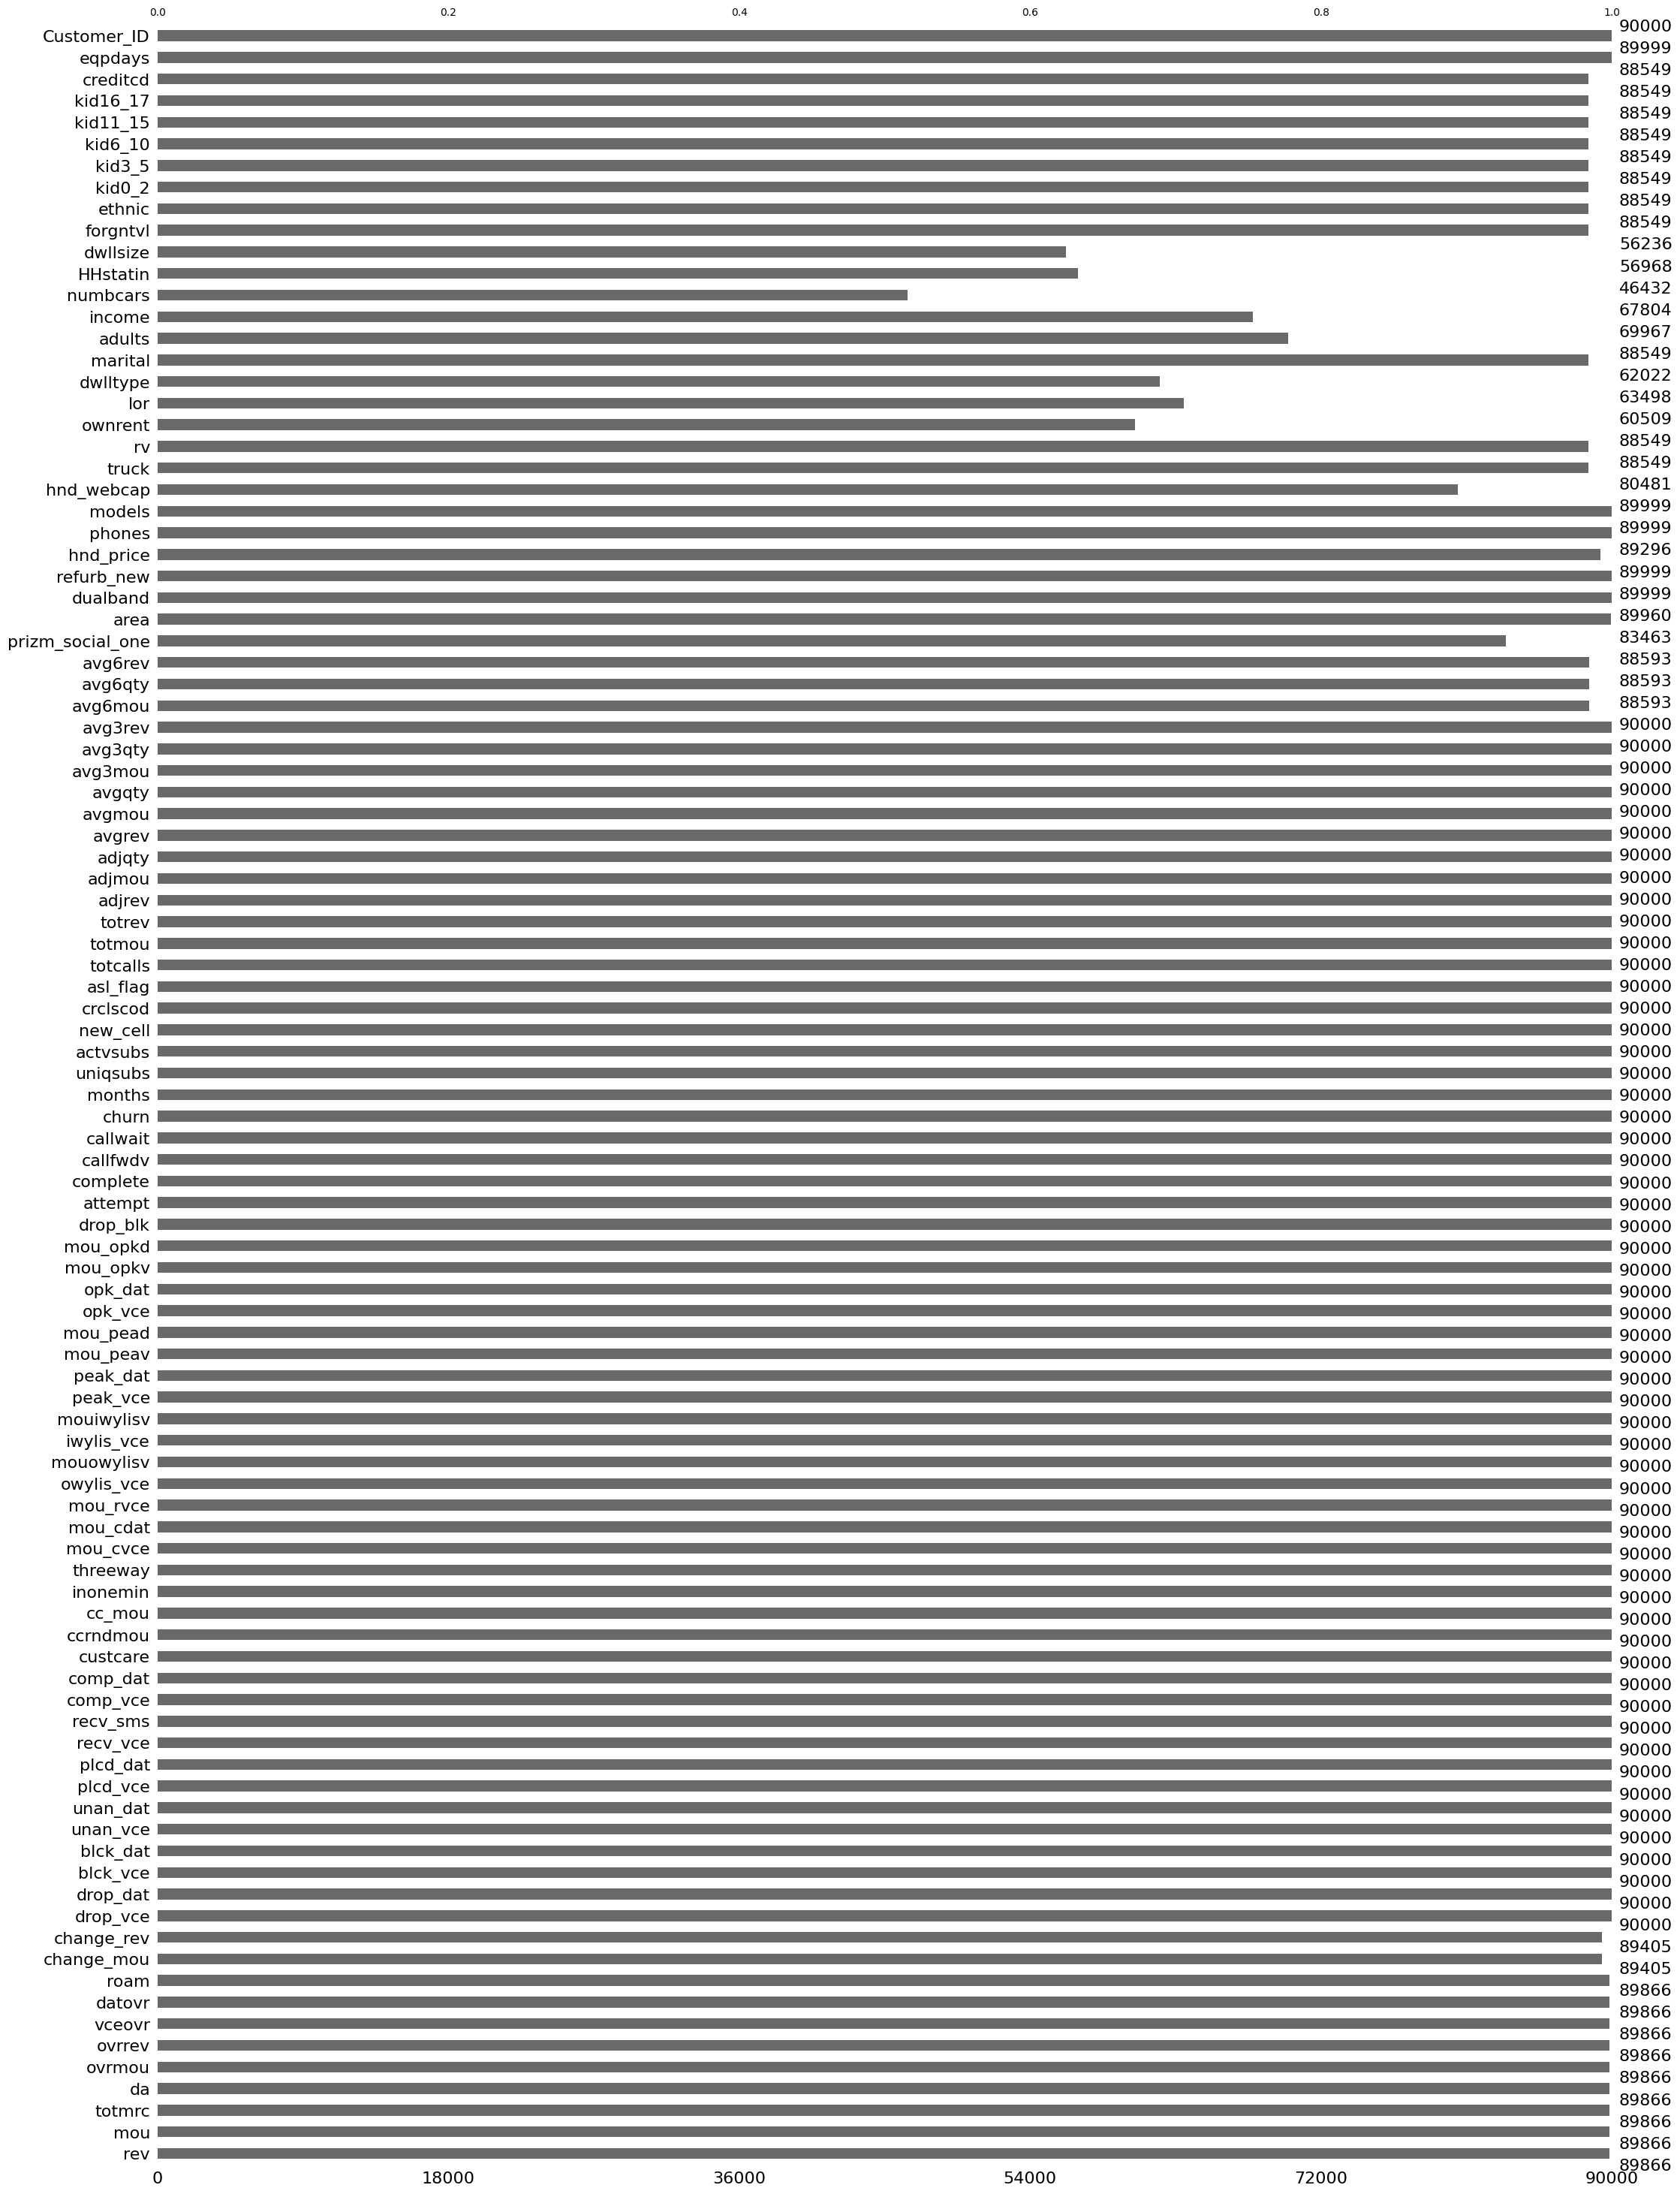

In [107]:
msno.bar(df3)

<Axes: >

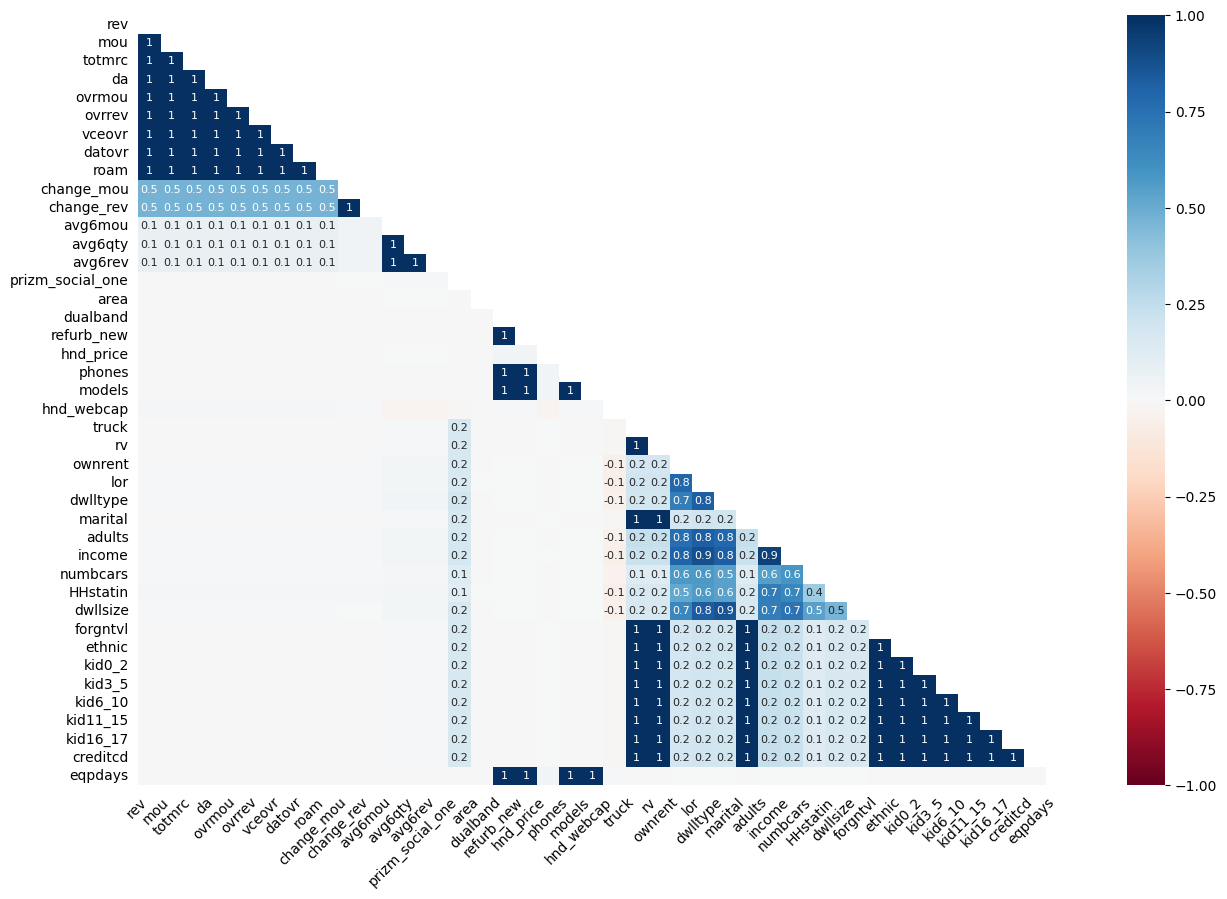

In [108]:
# Visualizar la correlación de valores nulos en un heatmap
msno.heatmap(df3, figsize=(15,10), fontsize=10)

In [109]:
# Calcular el porcentaje de valores nulos por columna
null_percentages = (df3.isnull().sum() / len(df3)) * 100

# Ordenar en orden descendente
null_percentages = null_percentages.sort_values(ascending=False)

# Mostrar las variables con mayor porcentaje de valores nulos
print("Variables con mayor porcentaje de valores nulos:")
print(null_percentages.head(10))  # Muestra las 10 variables con mayor porcentaje de nulos

Variables con mayor porcentaje de valores nulos:
numbcars            48.408889
dwllsize            37.515556
HHstatin            36.702222
ownrent             32.767778
dwlltype            31.086667
lor                 29.446667
income              24.662222
adults              22.258889
hnd_webcap          10.576667
prizm_social_one     7.263333
dtype: float64


<Axes: >

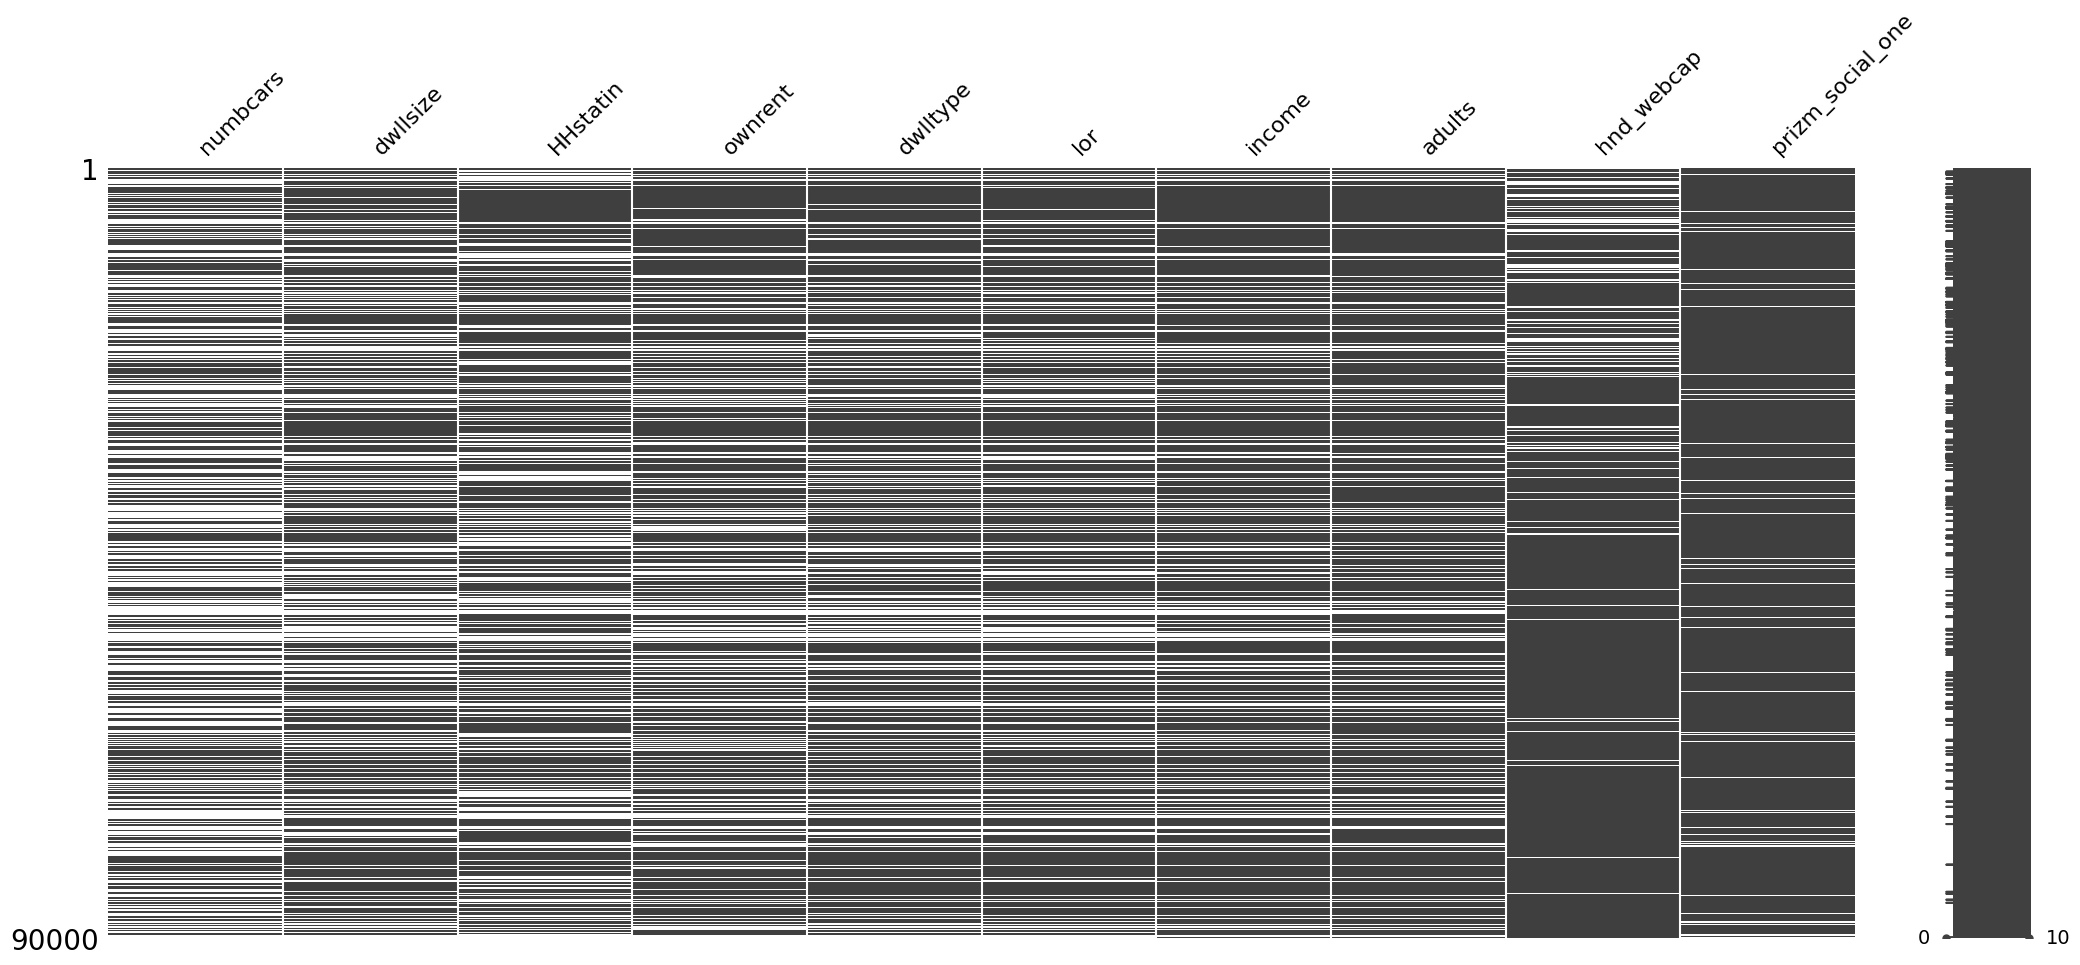

In [110]:
# Obtener los porcentajes de valores nulos y seleccionar las primeras filas (10 en este caso)
null_percentages = df3.isnull().mean()
top_null_columns = null_percentages.sort_values(ascending=False).head(10).index.tolist()

# Filtrar el DataFrame original por las columnas con los porcentajes más altos de valores nulos
df_top_nulls = df3[top_null_columns]

# Visualizar la matriz de Missingno con las columnas seleccionadas
msno.matrix(df_top_nulls)

In [111]:
#Listado de nulos con etiqueta para nulos ("U" o "Unknow" o similar)
df_report = \
(
    reportFeature(df3, nan_only=True)
    [reportFeature(df3, nan_only=True)["Unique(10)"].str.contains("U")]
)
df_report

,Nulos,Porcentaje,Tipo,N_Unique,Unique(10)
hnd_webcap,9519,10.58,object,3.0,['WCMB' 'WC' nan 'UNKW']
prizm_social_one,6537,7.26,object,5.0,['S' 'U' 'T' 'C' nan 'R']
kid16_17,1451,1.61,object,2.0,['U' 'Y' nan]
marital,1451,1.61,object,5.0,['S' 'M' 'A' 'U' 'B' nan]
ethnic,1451,1.61,object,16.0,['N' 'Z' 'U' 'I' 'S' 'F' 'J' 'M' 'H' 'G']
kid0_2,1451,1.61,object,2.0,['U' 'Y' nan]
kid3_5,1451,1.61,object,2.0,['U' 'Y' nan]
kid6_10,1451,1.61,object,2.0,['U' 'Y' nan]
kid11_15,1451,1.61,object,2.0,['U' 'Y' nan]
area,40,0.04,object,19.0,['NORTHWEST/ROCKY MOUNTAIN AREA' 'CHICAGO AREA' 'GREAT LAKES AREA'\n 'NEW ENGLAND AREA' 'DALLAS ...


In [131]:
# Función para registrar la operación en el log
def logImputationOperation(log_df, columns, imputation_label, category_operation, operation_description):
    for col in columns:
        log_df = log_df.append({
            'Column': col,
            'Operation': operation_description,
            'Category': category_operation,
            'ImputationLabel': imputation_label
        }, ignore_index=True)
    return log_df

# Imputación de nulos con la etiqueta "U"
lista_var = ['prizm_social_one', 'kid0_2', 'kid3_5', 'kid16_17', 'kid11_15', 'kid6_10', 'marital', 'ethnic', 'dualband','area']

for i in lista_var:
    df3[i].fillna("U", inplace=True)

# Registro de la operación en el log
category_operation = "Data Imputation"
operation_description = "Imputación de nulos con la etiqueta 'U'"
imputation_label = "U"

df_log = logImputationOperation(df_log, lista_var, imputation_label, category_operation, operation_description)

In [132]:
#Verificación
(
    reportFeature(df3, nan_only=True)
    [reportFeature(df3, nan_only=True)["Unique(10)"].str.contains("U")]
)

,Nulos,Porcentaje,Tipo,N_Unique,Unique(10)


In [116]:
df_log

,Variable,Tipo,Categoria,Operacion,Category,Operation,Column,Columns,ImputationLabel
0,infobase,object,Data Cleaning,Eliminar filas/columnas vacías y columnas irrelevantes',NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,Data Transformation,"Conversión a tipo 'Int64' de las variables: 'rv', 'forgntvl', 'truck', 'phones', 'lor', 'numbcar...",NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,Data Cleaning,Cambio de tipo de las columnas a 'float',avg3mou,NaN,NaN
3,NaN,NaN,NaN,NaN,Data Cleaning,Cambio de tipo de las columnas a 'float',avg3qty,NaN,NaN
4,NaN,NaN,NaN,NaN,Data Cleaning,Cambio de tipo de las columnas a 'float',avg3rev,NaN,NaN
5,NaN,NaN,NaN,NaN,Data Cleaning,Reemplazo de valores negativos por la moda de 'eqpdays',eqpdays,NaN,NaN
6,NaN,NaN,NaN,NaN,Data Cleaning,Imputación de nulos con etiqueta 'U',NaN,"prizm_social_one, kid0_2, kid3_5, kid16_17, kid11_15, kid6_10, marital, ethnic, dualband",NaN
7,NaN,NaN,NaN,NaN,Data Imputation,Imputación de nulos con la etiqueta 'U',prizm_social_one,NaN,U
8,NaN,NaN,NaN,NaN,Data Imputation,Imputación de nulos con la etiqueta 'U',kid0_2,NaN,U
9,NaN,NaN,NaN,NaN,Data Imputation,Imputación de nulos con la etiqueta 'U',kid3_5,NaN,U


In [124]:
# Función para registrar la operación de imputación de nulos con 'UNKW' en el log
def logImputationNulls(df_log, column, category_operation, operation_description):
    df_log = df_log.append({
        'Column': column,
        'Operation': operation_description,
        'Category': category_operation
    }, ignore_index=True)
    return df_log

# Columna con nulos a imputar como 'UNKW'
column_with_nulls = "hnd_webcap"

# Imputación de nulos con la etiqueta 'UNKW'
df3[column_with_nulls].fillna("UNKW", inplace=True)

# Registro en el log
category_operation_null = "Data Cleaning"
operation_null = "Imputación de nulos con etiqueta 'UNKW'"
df_log = logImputationNulls(df_log, column_with_nulls, category_operation_null, operation_null)

In [133]:
#Listado nulos categoricos pendientes

df_report = \
(
reportFeature(df3,nan_only=True)
[reportFeature(df3, nan_only=True)["Tipo"]=="object"]

)
df_report


,Nulos,Porcentaje,Tipo,N_Unique,Unique(10)


In [134]:
rows_to_select = ['dwllsize', 'HHstatin', 'ownrent', 'dwlltype', 'creditcd', 'refurb_new']
df_report = reportFeature(df3).filter(items=rows_to_select, axis=0)

In [126]:
df_desc[df_desc['Variable'].isin(['dwllsize', 'HHstatin', 'ownrent', 'dwlltype', 'creditcd', 'refurb_new'])]


,Variable,Description,Tipo
73,refurb_new,Handset: refurbished or new,object
80,ownrent,Home owner/renter status,object
82,dwlltype,Dwelling Unit type,object
88,HHstatin,Premier household status indicator,object
89,dwllsize,Dwelling size,object
97,creditcd,Credit card indicator,object


In [122]:
df3['creditcd'] = df3['creditcd'].astype('object')


In [127]:
# Imputación de nulos con etiqueta 'U' para el resto de nulos"

# Registro de Log
category_operation_impute = "Data Cleaning"
operation_impute = "Imputación de nulos con etiqueta 'U' para el resto de nulos"

# Lista de variables a procesar
lista_var = ['dwllsize', 'HHstatin', 'ownrent', 'dwlltype', 'creditcd', 'refurb_new']

# Imputar nulos con la etiqueta 'U' para categorías con 1 caracter
for col in lista_var:
    df3[col].fillna("U", inplace=True)


In [142]:
#VARIABLES NUMÉRICAS

df_report = \
(
reportFeature(df3,nan_only=True)
[reportFeature(df3, nan_only=True)["Tipo"]!="object"]

)
df_report

,Nulos,Porcentaje,Tipo,N_Unique,Unique(10)


In [137]:
df_desc[df_desc['Variable'].isin(['phones', 'models', 'truck', 'rv', 'lor', 'adults', 'income', 'numbcars', 'forgntvl', 'eqpdays'])]


,Variable,Description,Tipo
75,phones,Number of handsets issued,float64
76,models,Number of models issued,float64
78,truck,Truck indicator,float64
79,rv,RV indicator,float64
81,lor,Length of residence,float64
84,adults,Number of adults in household,float64
86,income,Estimated income,float64
87,numbcars,Known number of vehicles,float64
90,forgntvl,Foreign travel dummy variable,float64
98,eqpdays,Number of days (age) of current equipment,float64


In [138]:
df_estats = df3[df_report.index].describe().T
df_estats["Mediana"] = df3[df_report.index].median().T

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

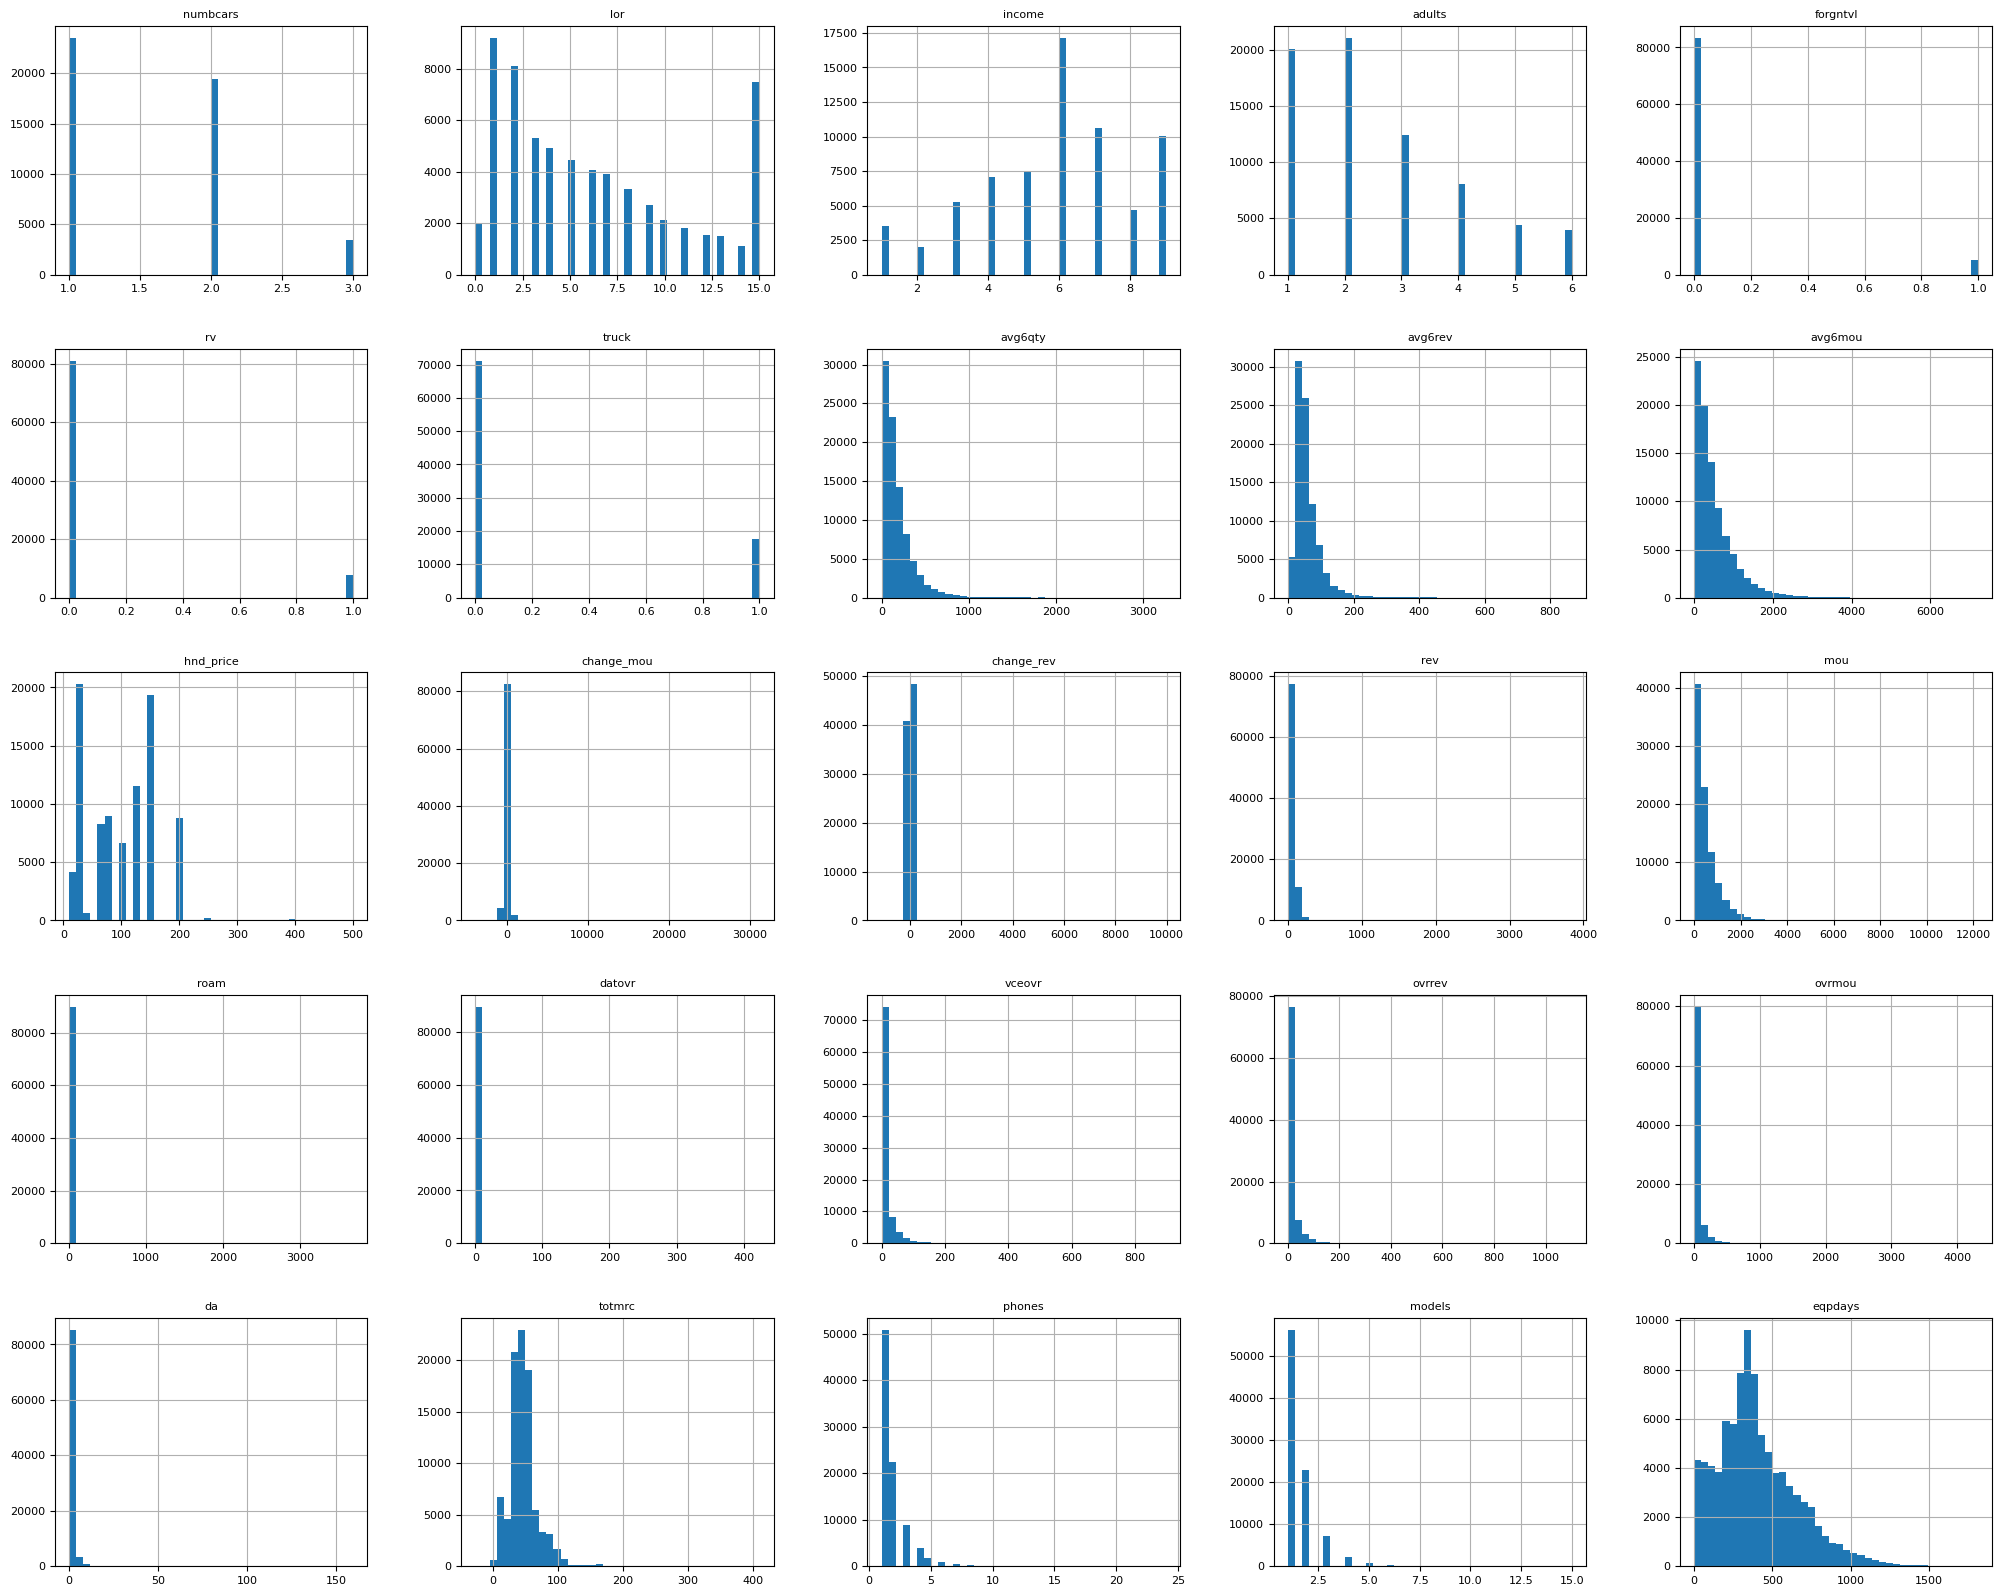

In [139]:
fig = df3[df_report.index.values].hist(figsize=(25,20), xlabelsize=8, ylabelsize=8, bins=40)
[x.title.set_size(8) for x in fig.ravel()]

In [140]:
#Las variables numericas tienen distribucion asimétrica a la derecha, por lo que aparenta ser recomendable la utilización de la mediana
#para imputación de nulos

#en distribuciones asimétricas hacia la derecha, donde la media se ve afectada por valores atípicos o extremadamente altos,
#la mediana es una medida más robusta y a menudo preferible como medida central

#Registro de Log
category_operation = "Data Cleaning"
operation = "Imputación de nulos utilizando la mediana en variables numéricas con distribución asimétrica a la derecha"

# Descripción de las estadísticas para obtener la distribución de las columnas
df_estats = df3.describe().T

# Obtener las columnas numéricas
numeric_columns = df_estats.index

# Iterar sobre las columnas y rellenar los valores nulos con la mediana de cada columna
for column in numeric_columns:
    median_col = df3[column].median()
    df3[column].fillna(median_col, inplace=True)

def logImputationOperation(dataset_log, list_variable, cat_operation, operation):
    for var in list_variable:
        dataset_log = dataset_log.append({'Variable': var, 'Category': cat_operation, 'Operation': operation}, ignore_index=True)
    return dataset_log

# Lista de columnas que se han imputado con la mediana
numeric_columns = df_estats.index

# Registra la imputación de nulos con la mediana para cada columna numérica
category_operation_median = "Data Cleaning"
operation_description_median = "Imputación de nulos con la mediana"

df_log = logImputationOperation(df_log, numeric_columns, category_operation_median, operation_description_median)

In [141]:
(
reportFeature(df3,nan_only=True)
[reportFeature(df3, nan_only=True)["Tipo"]!="object"]

)

,Nulos,Porcentaje,Tipo,N_Unique,Unique(10)


In [143]:
df3["rv"].describe()

count     90000.0
mean     0.085467
std      0.279576
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           1.0
Name: rv, dtype: Float64

In [144]:
df_desc[df_desc['Variable'].isin(["forgntvl", "rv", "truck"])]


,Variable,Description,Tipo
78,truck,Truck indicator,float64
79,rv,RV indicator,float64
90,forgntvl,Foreign travel dummy variable,float64


In [145]:
#Las variables "forgntvl", "rv", "truck" son binárias entre 0 y 1.
#Por lo tanto, pueden ser convertidas a "int" y los nulos imputados con outlier para ese valor (-1)

binary_columns = []

for column in df3.columns:
    unique_values = df3[column].dropna().unique()  # Obtiene los valores únicos excluyendo los valores nulos
    if len(unique_values) == 2 and 0 in unique_values and 1 in unique_values:
        binary_columns.append(column)

# Las columnas en 'binary_columns' son las que contienen valores binarios (0 y 1)
print("Columnas binarias entre 0 y 1:", binary_columns)



Columnas binarias entre 0 y 1: ['churn', 'truck', 'rv', 'forgntvl']


In [146]:
def logConversionToIntAndFillNa(dataset_log, columns_to_process, operation_description):
    category_operation = "Data Cleaning"

    for col in columns_to_process:
        dataset_log = dataset_log.append({'Variable': col, 'Category': category_operation, 'Operation': operation_description}, ignore_index=True)

    return dataset_log

# Columnas a procesar
lista_var = ["forgntvl", "rv", "truck"]

# Convertir a tipo de dato int y rellenar nulos con -1
for column in lista_var:
    df3[column] = df3[column].fillna(-1).astype("int8")

# Registro en el log
operation_description = "Conversión a tipo int y relleno de nulos con -1"
df_log = logConversionToIntAndFillNa(df_log, lista_var, operation_description)

#Verificación

df_report = reportFeature(df3[lista_var])
df_report



,Nulos,Porcentaje,Tipo,N_Unique,Unique(10)
forgntvl,0,0.0,int8,2.0,[0 1]
rv,0,0.0,int8,2.0,[0 1]
truck,0,0.0,int8,2.0,[0 1]


In [147]:
columns_to_describe = ["forgntvl", "rv", "truck"]
print(df3[columns_to_describe].describe())

       forgntvl      rv            truck       
count  90000.000000  90000.000000  90000.000000
mean       0.058300      0.085467      0.194011
std        0.234311      0.279576      0.395440
min        0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000
50%        0.000000      0.000000      0.000000
75%        0.000000      0.000000      0.000000
max        1.000000      1.000000      1.000000


In [151]:
# Verificación de nulos
reportFeature(df3, nan_only=True)

,Nulos,Porcentaje,Tipo,N_Unique,Unique(10)


In [152]:
df3.isnull().sum()

rev                 0
mou                 0
totmrc              0
da                  0
ovrmou              0
ovrrev              0
vceovr              0
datovr              0
roam                0
change_mou          0
change_rev          0
drop_vce            0
drop_dat            0
blck_vce            0
blck_dat            0
unan_vce            0
unan_dat            0
plcd_vce            0
plcd_dat            0
recv_vce            0
recv_sms            0
comp_vce            0
comp_dat            0
custcare            0
ccrndmou            0
cc_mou              0
inonemin            0
threeway            0
mou_cvce            0
mou_cdat            0
mou_rvce            0
owylis_vce          0
mouowylisv          0
iwylis_vce          0
mouiwylisv          0
peak_vce            0
peak_dat            0
mou_peav            0
mou_pead            0
opk_vce             0
opk_dat             0
mou_opkv            0
mou_opkd            0
drop_blk            0
attempt             0
complete  

In [148]:
df_log

,Variable,Tipo,Categoria,Operacion,Category,Operation,Column,Columns,ImputationLabel
0,infobase,object,Data Cleaning,Eliminar filas/columnas vacías y columnas irrelevantes',NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,Data Transformation,"Conversión a tipo 'Int64' de las variables: 'rv', 'forgntvl', 'truck', 'phones', 'lor', 'numbcar...",NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,Data Cleaning,Cambio de tipo de las columnas a 'float',avg3mou,NaN,NaN
3,NaN,NaN,NaN,NaN,Data Cleaning,Cambio de tipo de las columnas a 'float',avg3qty,NaN,NaN
4,NaN,NaN,NaN,NaN,Data Cleaning,Cambio de tipo de las columnas a 'float',avg3rev,NaN,NaN
5,NaN,NaN,NaN,NaN,Data Cleaning,Reemplazo de valores negativos por la moda de 'eqpdays',eqpdays,NaN,NaN
6,NaN,NaN,NaN,NaN,Data Cleaning,Imputación de nulos con etiqueta 'U',NaN,"prizm_social_one, kid0_2, kid3_5, kid16_17, kid11_15, kid6_10, marital, ethnic, dualband",NaN
7,NaN,NaN,NaN,NaN,Data Imputation,Imputación de nulos con la etiqueta 'U',prizm_social_one,NaN,U
8,NaN,NaN,NaN,NaN,Data Imputation,Imputación de nulos con la etiqueta 'U',kid0_2,NaN,U
9,NaN,NaN,NaN,NaN,Data Imputation,Imputación de nulos con la etiqueta 'U',kid3_5,NaN,U


# Encoding categóricos

* Si tienen sentido ordinal, es decir, se pueden ordenar, encodear con una escala numerica. Ejemplo: {"Bajo":1, "Medio":2, "Alto":3}.
* Si tienen unicamente 2 clases, indicador booleano
* One Hot Encoding en resto de categoricos

In [155]:
#Copia de seguridad
df4 = df3.copy()
category_operation = "Encoding Categóricos"



In [156]:
#Listado de variables categóricas
df_report=\
(
reportFeature(df4)
[reportFeature(df4)["Tipo"]=="object"]
)
df_report

,Nulos,Porcentaje,Tipo,N_Unique,Unique(10)
dualband,0,0.0,object,4.0,['Y' 'N' 'T' 'U']
area,0,0.0,object,20.0,['NORTHWEST/ROCKY MOUNTAIN AREA' 'CHICAGO AREA' 'GREAT LAKES AREA'\n 'NEW ENGLAND AREA' 'DALLAS ...
prizm_social_one,0,0.0,object,5.0,['S' 'U' 'T' 'C' 'R']
asl_flag,0,0.0,object,2.0,['N' 'Y']
crclscod,0,0.0,object,54.0,['A' 'EA' 'C' 'B' 'BA' 'D' 'G' 'CA' 'I' 'AA']
new_cell,0,0.0,object,3.0,['U' 'N' 'Y']
refurb_new,0,0.0,object,3.0,['N' 'R' 'U']
creditcd,0,0.0,object,3.0,['Y' 'N' 'U']
kid16_17,0,0.0,object,2.0,['U' 'Y']
kid11_15,0,0.0,object,2.0,['U' 'Y']


In [160]:
#Las variables con valores entre "Y" y "U" parecen no ser representativa porque, efectivamente, solo contienen "Y" además de "U" - nulo. És decir, o el valor es "Y", o no es conocido.
# "Eliminar variables con valores entre 'Y' y 'U' "

def logColumnDrop(log_df, category_operation, operation_description, columns_dropped):
    log_df = log_df.append({'Category': category_operation, 'Operation': operation_description, 'ColumnsDropped': columns_dropped}, ignore_index=True)
    return log_df

# Lista de columnas a eliminar
columns_to_drop = ['kid16_17', 'kid11_15', 'kid6_10', 'kid3_5', 'kid0_2']

# Registro de la eliminación de columnas en el log
category_operation = "Data Cleaning"
operation_description = "Eliminar columnas específicas"
df_log = logColumnDrop(df_log, category_operation, operation_description, columns_to_drop)

# Aplicar la eliminación de columnas
df.drop(columns=columns_to_drop, inplace=True)

In [161]:
#verificacion
lista_drop in df4.columns.values

False

In [165]:
#Categorización de las áreas en la variable "area" por Regioneas Administrativas* - disminución de cardinalidad
# *(de EE.UU - https://es.wikipedia.org/wiki/Regiones_de_Estados_Unidos)

#dict_area = {"Northeast": ["NEW ENGLAND AREA"],
 #            "Mid-Atlantic": ["PHILADELPHIA AREA","NEW YORK CITY AREA"],
  #            "South": ["TENNESSEE AREA","ATLANTIC SOUTH AREA","SOUTH FLORIDA AREA","DC/MARYLAND/VIRGINIA AREA","NORTH FLORIDA AREA"],
   #            "Midwest": ["CHICAGO AREA", "GREAT LAKES AREA", "MIDWEST AREA","OHIO AREA"],
    #            "West": ["NORTHWEST/ROCKY MOUNTAIN AREA", "CALIFORNIA NORTH AREA","LOS ANGELES AREA"],
     #           "Southwest": ["DALLAS AREA", "CENTRAL/SOUTH TEXAS AREA","HOUSTON AREA","SOUTHWEST AREA"]
      #           }


dict_area = {"NEW ENGLAND AREA": "NORTHEAST" ,
             "PHILADELPHIA AREA":"MID-ATLANTIC",
             "NEW YORK CITY AREA": "MID-ATLANTIC",
              "TENNESSEE AREA": "SOUTH",
              "ATLANTIC SOUTH AREA": "SOUTH",
              "SOUTH FLORIDA AREA": "SOUTH",
              "DC/MARYLAND/VIRGINIA AREA": "SOUTH",
              "NORTH FLORIDA AREA": "SOUTH",
               "CHICAGO AREA": "MIDWEST",
                "GREAT LAKES AREA": "MIDWEST",
                "MIDWEST AREA": "MIDWEST",
                "OHIO AREA": "MIDWEST",
                "NORTHWEST/ROCKY MOUNTAIN AREA": "WEST",
                "CALIFORNIA NORTH AREA": "WEST",
                "LOS ANGELES AREA": "WEST",
                "DALLAS AREA": "SOUTHWEST",
                "CENTRAL/SOUTH TEXAS AREA": "SOUTHWEST",
                "HOUSTON AREA": "SOUTHWEST",
                "SOUTHWEST AREA": "SOUTHWEST",}


df4["area_ENCOD"] = df4["area"].replace(dict_area)
df4["area_ENCOD"].unique()


array(['WEST', 'MIDWEST', 'NORTHEAST', 'SOUTHWEST', 'SOUTH',
       'MID-ATLANTIC', 'U'], dtype=object)

In [166]:
# Eliminar la columna "area"
df4.drop(columns=["area"], inplace=True)

# Registro de la operación en el log
category_operation = "Data Cleaning"
operation_description = "Eliminación de la variable 'area'"
df_log = logOperation(df_log, category_operation, operation_description)

In [167]:
#Verificacion:
"area" in df4.columns

False

In [168]:
#Variable "asl_flag" es binaria entre 'Y' y 'N'.

# Registro de Log
category_operation = "Data Transformation"
operation = "Aplicación de identificador binario para 'asl_flag'"

# Aplicar LabelEncoder para 'asl_flag'
le = LabelEncoder()
df4["asl_flag_BOOL"] = le.fit_transform(df4["asl_flag"])

# Registra la operación en el log
log_entry = {
    'Category': category_operation,
    'Operation': operation,
    'ColumnTransformed': "asl_flag_BOOL",
    'OriginalColumn': "asl_flag"
}
df_log = df_log.append(log_entry, ignore_index=True)

# Verificación
print(df4["asl_flag_BOOL"].value_counts())
print(df4["asl_flag"].value_counts())

0    79401
1    10599
Name: asl_flag_BOOL, dtype: int64
N    79401
Y    10599
Name: asl_flag, dtype: int64


In [169]:
df_report=\
(
reportFeature(df4)
[reportFeature(df4)["Tipo"]=="object"]
)
df_report

,Nulos,Porcentaje,Tipo,N_Unique,Unique(10)
dualband,0,0.0,object,4.0,['Y' 'N' 'T' 'U']
asl_flag,0,0.0,object,2.0,['N' 'Y']
crclscod,0,0.0,object,54.0,['A' 'EA' 'C' 'B' 'BA' 'D' 'G' 'CA' 'I' 'AA']
new_cell,0,0.0,object,3.0,['U' 'N' 'Y']
prizm_social_one,0,0.0,object,5.0,['S' 'U' 'T' 'C' 'R']
refurb_new,0,0.0,object,3.0,['N' 'R' 'U']
area_ENCOD,0,0.0,object,7.0,['WEST' 'MIDWEST' 'NORTHEAST' 'SOUTHWEST' 'SOUTH' 'MID-ATLANTIC' 'U']
creditcd,0,0.0,object,3.0,['Y' 'N' 'U']
ethnic,0,0.0,object,16.0,['N' 'Z' 'U' 'I' 'S' 'F' 'J' 'M' 'H' 'G']
dwllsize,0,0.0,object,16.0,['A' 'D' 'O' 'U' 'E' 'J' 'C' 'B' 'I' 'N']


In [170]:
df_desc[df_desc['Variable'].isin(['dualband', 'asl_flag', 'crclscod','prizm_social_one', 'new_cell', 'prizm_social_one', 'refurb_new', 'area_ENCOD', 'creditcd', 'ethnic', 'dwllsize', 'HHstatin', 'marital', 'dwlltype', 'ownrent', 'hnd_webcap'])]


,Variable,Description,Tipo
52,new_cell,New cell phone user,object
53,crclscod,Credit class code,object
54,asl_flag,Account spending limit,object
70,prizm_social_one,Social group letter only,object
72,dualband,Dualband,object
73,refurb_new,Handset: refurbished or new,object
77,hnd_webcap,Handset web capability,object
80,ownrent,Home owner/renter status,object
82,dwlltype,Dwelling Unit type,object
83,marital,Marital Status,object


In [171]:
df_report.index


Index(['dualband', 'asl_flag', 'crclscod', 'new_cell', 'prizm_social_one',
       'refurb_new', 'area_ENCOD', 'creditcd', 'ethnic', 'dwllsize',
       'HHstatin', 'marital', 'dwlltype', 'ownrent', 'hnd_webcap'],
      dtype='object')

In [172]:
#Listado de variables categóricas
df_report=\
(
reportFeature(df4)
[reportFeature(df4)["Tipo"]=="object"]
)
df_report

,Nulos,Porcentaje,Tipo,N_Unique,Unique(10)
dualband,0,0.0,object,4.0,['Y' 'N' 'T' 'U']
asl_flag,0,0.0,object,2.0,['N' 'Y']
crclscod,0,0.0,object,54.0,['A' 'EA' 'C' 'B' 'BA' 'D' 'G' 'CA' 'I' 'AA']
new_cell,0,0.0,object,3.0,['U' 'N' 'Y']
prizm_social_one,0,0.0,object,5.0,['S' 'U' 'T' 'C' 'R']
refurb_new,0,0.0,object,3.0,['N' 'R' 'U']
area_ENCOD,0,0.0,object,7.0,['WEST' 'MIDWEST' 'NORTHEAST' 'SOUTHWEST' 'SOUTH' 'MID-ATLANTIC' 'U']
creditcd,0,0.0,object,3.0,['Y' 'N' 'U']
ethnic,0,0.0,object,16.0,['N' 'Z' 'U' 'I' 'S' 'F' 'J' 'M' 'H' 'G']
dwllsize,0,0.0,object,16.0,['A' 'D' 'O' 'U' 'E' 'J' 'C' 'B' 'I' 'N']


In [173]:
columns_to_check = ['dualband', 'asl_flag', 'crclscod', 'new_cell', 'prizm_social_one', 'refurb_new']

for col in columns_to_check:
    null_count = df4[col].isnull().sum()
    print(f"Valores nulos en {col}: {null_count}")

Valores nulos en dualband: 0
Valores nulos en asl_flag: 0
Valores nulos en crclscod: 0
Valores nulos en new_cell: 0
Valores nulos en prizm_social_one: 0
Valores nulos en refurb_new: 0


In [175]:
categories = list(df4.select_dtypes(include='object').columns)
print('Variables categoricas a encodear:', categories)

Variables categoricas a encodear: ['new_cell', 'crclscod', 'asl_flag', 'prizm_social_one', 'dualband', 'refurb_new', 'hnd_webcap', 'ownrent', 'dwlltype', 'marital', 'HHstatin', 'dwllsize', 'ethnic', 'creditcd', 'area_ENCOD']


In [176]:
# Realizar One Hot Encoding
df4 = pd.get_dummies(df4, columns=categories)

# Después de realizar la operación, registrarla en el log
category_operation = "One Hot Encoding"
operation = "Codificación de variables categóricas con One Hot Encoding"
columns_dropped = []  # Define esta variable como una lista vacía o con las columnas eliminadas, si las hay

# Registra la operación en el log
log_entry = {'Category': category_operation, 'Operation': operation, 'ColumnsDropped': columns_dropped}
df_log = df_log.append(log_entry, ignore_index=True)

# Verificar las columnas en df4 después del One Hot Encoding
print(df4.columns)

Index(['rev', 'mou', 'totmrc', 'da', 'ovrmou', 'ovrrev', 'vceovr', 'datovr',
       'roam', 'change_mou',
       ...
       'creditcd_N', 'creditcd_U', 'creditcd_Y', 'area_ENCOD_MID-ATLANTIC',
       'area_ENCOD_MIDWEST', 'area_ENCOD_NORTHEAST', 'area_ENCOD_SOUTH',
       'area_ENCOD_SOUTHWEST', 'area_ENCOD_U', 'area_ENCOD_WEST'],
      dtype='object', length=214)


In [177]:
#eliminación de variebles categoricas OHE originarias
df4.drop(columns=lista_var, inplace=True)

In [178]:
df4.head(3)

,rev,mou,totmrc,da,ovrmou,ovrrev,vceovr,datovr,roam,change_mou,change_rev,drop_vce,drop_dat,blck_vce,blck_dat,unan_vce,unan_dat,plcd_vce,plcd_dat,recv_vce,recv_sms,comp_vce,comp_dat,custcare,ccrndmou,cc_mou,inonemin,threeway,mou_cvce,mou_cdat,mou_rvce,owylis_vce,mouowylisv,iwylis_vce,mouiwylisv,peak_vce,peak_dat,mou_peav,mou_pead,opk_vce,opk_dat,mou_opkv,mou_opkd,drop_blk,attempt,complete,callfwdv,callwait,churn,months,uniqsubs,actvsubs,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,hnd_price,phones,models,lor,adults,income,numbcars,eqpdays,Customer_ID,asl_flag_BOOL,new_cell_N,new_cell_U,new_cell_Y,crclscod_A,crclscod_A2,crclscod_A3,crclscod_AA,crclscod_B,crclscod_B2,crclscod_BA,crclscod_C,crclscod_C2,crclscod_C5,crclscod_CA,crclscod_CC,crclscod_CY,crclscod_D,crclscod_D2,crclscod_D4,crclscod_D5,crclscod_DA,crclscod_E,crclscod_E2,crclscod_E4,crclscod_EA,crclscod_EC,crclscod_EF,crclscod_EM,crclscod_G,crclscod_GA,crclscod_GY,crclscod_H,crclscod_I,crclscod_IF,crclscod_J,crclscod_JF,crclscod_K,crclscod_L,crclscod_M,crclscod_O,crclscod_P1,crclscod_S,crclscod_TP,crclscod_U,crclscod_U1,crclscod_V,crclscod_V1,crclscod_W,crclscod_Y,crclscod_Z,crclscod_Z1,crclscod_Z2,crclscod_Z4,crclscod_Z5,crclscod_ZA,crclscod_ZF,crclscod_ZY,asl_flag_N,asl_flag_Y,prizm_social_one_C,prizm_social_one_R,prizm_social_one_S,prizm_social_one_T,prizm_social_one_U,dualband_N,dualband_T,dualband_U,dualband_Y,refurb_new_N,refurb_new_R,refurb_new_U,hnd_webcap_UNKW,hnd_webcap_WC,hnd_webcap_WCMB,ownrent_O,ownrent_R,ownrent_U,dwlltype_M,dwlltype_S,dwlltype_U,marital_A,marital_B,marital_M,marital_S,marital_U,HHstatin_A,HHstatin_B,HHstatin_C,HHstatin_G,HHstatin_H,HHstatin_I,HHstatin_U,dwllsize_A,dwllsize_B,dwllsize_C,dwllsize_D,dwllsize_E,dwllsize_F,dwllsize_G,dwllsize_H,dwllsize_I,dwllsize_J,dwllsize_K,dwllsize_L,dwllsize_M,dwllsize_N,dwllsize_O,dwllsize_U,ethnic_B,ethnic_D,ethnic_F,ethnic_G,ethnic_H,ethnic_I,ethnic_J,ethnic_M,ethnic_N,ethnic_O,ethnic_P,ethnic_R,ethnic_S,ethnic_U,ethnic_X,ethnic_Z,creditcd_N,creditcd_U,creditcd_Y,area_ENCOD_MID-ATLANTIC,area_ENCOD_MIDWEST,area_ENCOD_NORTHEAST,area_ENCOD_SOUTH,area_ENCOD_SOUTHWEST,area_ENCOD_U,area_ENCOD_WEST
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,-18.9975,0.666667,0.0,0.666667,0.0,6.333333,0.0,52.333333,0.0,42.333333,0.0,45.000000,0.0,0.000000,0.000000,0.000000,18.000000,0.000000,90.643333,0.0,97.176667,0.000000,0.000000,0.000000,0.000000,58.000000,0.0,132.600000,0.0,24.0,0.0,55.220000,0.0,1.333333,52.333333,45.000000,0.0,0.333333,1,61,2,1,1652,4228.00000,1504.62,1453.44,4085.00,1602,29.66,83.37,32.69,272.0,116.0,30.0,322.0,136.0,38.0,149.98999,2,2,15,1,4,3,361,1000001,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,50.9875,8.333333,0.0,1.000000,0.0,61.333333,0.0,263.333333,0.0,69.000000,0.0,193.333333,0.0,1.666667,6.333333,5.463333,53.000000,0.333333,189.396667,0.0,55.280000,46.333333,24.216667,6.333333,3.696667,83.666667,0.0,75.333333,0.0,157.0,0.0,169.343333,0.0,9.333333,263.333333,193.333333,0.0,5.666667,0,56,1,1,14654,26400.00000,2851.68,2833.88,26367.00,14624,51.53,479.40,265.89,305.0,158.0,40.0,477.0,275.0,48.0,99.98999,7,6,1,1,5,1,240,1000002,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,0.0000,0.333333,0.0,0.000000,0.0,2.666667,0.0,9.000000,0.0,0.333333,0.0,6.000000,0.0,0.000000,0.000000,0.000000,0.333333,0.000000,5.426667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,

In [179]:
df3.shape

(90000, 99)

In [180]:
df4.shape

(90000, 211)

In [181]:
#Listado de variables categóricas
df_report=\
(
reportFeature(df4)
[reportFeature(df4)["Tipo"]=="object"]
)
df_report

,Nulos,Porcentaje,Tipo,N_Unique,Unique(10)


# Eliminar alta correlación

* Analizar variables (X) altamente correlacionadas
* Eliminar una variable de cada pareja altamente correlacionada (>95% o >99%...) en el dataset (df)

In [ ]:
#Cópia de seguridad
df5 = df4.copy()
category_operation="Eliminar alta correlación"

#Split X-y
features = df5.columns[df5.columns!=target]

X = df5[features]
y = df5[target]

def highly_correlated(X, y, threshold):
    col_corr = list() # Set of all the names of deleted columns
    colnames = list()
    rownames = list()
    corr_matrix = X.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colnames.append(corr_matrix.columns[i]) # getting the name of column
                rownames.append(corr_matrix.index[j])
                col_corr.append(corr_matrix.iloc[i, j])
    Z = pd.DataFrame({'F1':colnames,
                      'F2':rownames,
                      'corr_F1_F2':col_corr,
                      'corr_F1_target': [np.abs(np.corrcoef(X[i],y)[0,1]) for i in colnames],
                      'corr_F2_target': [np.abs(np.corrcoef(X[i],y)[0,1]) for i in rownames]
                      })
    Z['F_to_delete'] = rownames
    Z['F_to_delete'][Z['corr_F1_target'] < Z['corr_F2_target']] = Z['F1'][Z['corr_F1_target'] < Z['corr_F2_target']]

    return Z

highly_corr = highly_correlated(X,y,0.95)
highly_corr

In [ ]:
#Eliminar variables con alta correlación

# Registro en el log
category_operation = "Eliminar variables con alta correlación"
operation = "Eliminación de variables basadas en alta correlación"
columns_dropped = lista_var

# Crear el registro log
log_entry = {'Category': category_operation, 'Operation': operation, 'ColumnsDropped': columns_dropped}
# Suponiendo que df_log es el DataFrame donde guardas el registro log
df_log = df_log.append(log_entry, ignore_index=True)

In [ ]:
#verificación
for i in lista_var:
    print(i in highly_corr.columns)

In [ ]:
lista_var

# Eliminar baja varianza

* Eliminar variables (X) practicamente constantes con un threshold minimo (1% o menos)

In [ ]:
features = df5.columns[df5.columns!=target]
X = df5[features]
#Eliminamos columnas donde el 99% de los valores son iguales
vt = VarianceThreshold(threshold = 0.01)
vt.fit(X)
cols_lowvar = X.columns[vt.get_support()==False]
print(len(cols_lowvar),' low variance features will be removed:\n', cols_lowvar.to_list())

In [ ]:
df_report = reportFeature(df5)

#Eliminar variables con baja varianza
df5.drop(columns=cols_lowvar,inplace=True)

# Registro en el log
category_operation = "Eliminar variables con baja varianza"
operation = "Eliminación de variables basadas en baja varianza"
columns_dropped = cols_lowvar

# Crear el registro log
log_entry = {'Category': category_operation, 'Operation': operation, 'ColumnsDropped': columns_dropped}
# Suponiendo que df_log es el DataFrame donde guardas el registro log
df_log = df_log.append(log_entry, ignore_index=True)

In [ ]:
X.shape

In [ ]:
#Informe de variables en el DF
reportFeature(df5)

In [ ]:
#Listado de variables categóricas
df_report=\
(
reportFeature(df5)
[reportFeature(df5)["Tipo"]=="object"]
)
df_report

# Guardar clean data

* Guardar en data path y mostrar el resultado en un head()

In [ ]:
# Guardar los datos limpios en un archivo CSV
#df_clean.to_csv('data_path/nombre_archivo.csv', index=False)  # Cambia 'nombre_archivo.csv' por el nombre que desees

In [ ]:
# Mostrar las primeras filas del archivo CSV guardado
#ruta_archivo = 'data_path/nombre_archivo.csv'  # Ruta del archivo CSV guardado
#df_mostrado = pd.read_csv(ruta_archivo)  # Leer el archivo CSV
#print(df_mostrado.head())  # Mostrar las primeras filas del DataFrame leído desde el archivo

In [ ]:
CWD = os.getcwd()
CWD

In [ ]:
CWD = os.getcwd()

DATA_PATH = CWD+"/content/drive/MyDrive/NUCLIO/Machine Learning/Segundo entregable - ML/EJERCICIO-ML-Sup/data"
DATA_PATH


In [ ]:

# Ruta al directorio en tu Google Drive
DATA_PATH = '/content/drive/MyDrive/NUCLIO/Machine Learning/Segundo entregable - ML/EJERCICIO-ML-Sup/data'

# Comprobación y creación del directorio si no existe
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

In [ ]:

# Guardar el DataFrame df5 como un archivo pickle
df5.to_pickle(os.path.join(DATA_PATH, 'df_clean'))

# Guardar el DataFrame df_log como un archivo pickle
df_log.to_pickle(os.path.join(DATA_PATH, 'df_log'))